# 2. Fasea: Algoritmoak diseinatzen

**Julen Etxaniz eta Aitor Zubillaga**

Community Detection proiektuaren 1. fasea entregatu duzue, eta feedback-a jaso ere. Klasean hainbat algoritmo ikusi ditugu, batzuk soluzio bakarrean oinarritutakoak, beste batzuk aldiz, populazio bat erabiltzen dutenak. Horiez gain, hibridatzeko teknikak ere ikusi ditugu. Bigarrengo fase honetan, bi algoritmo diseinatu beharko dituzue, bata soluzio bakarrean oinarritutakoa, eta bestea poblazionala. Ez hori bakarrik, bi algoritmoetako batek operadore probabilistikoak erabili beharko ditu, Estimation of Distribution Algorithms (EDAk) edo Ant Colony Optimization (ACO)-ek egiten duten bezala. Algoritmoen helburua, komunitate kopuru jakin bat emanik, modularity maximizatzen duen komunitate banaketa (soluzioa) bilatzen saiatzea da.

Errepasatu gaitegian zehar ikusi ditugun algoritmo guztiak, eta horiek kontuak izanik, libre zarete nahi dituzuen diseinuak sortzeko, baita ere hibridoak! Adi! Egiten duzuen aukeraketa argudiatu egin beharko duzue.


#### Entregablea

Bigarrengo fasea ebaluatu ahal izateko, notebook honetan bertan algoritmoen diseinua eta implementazioa proposatu beharko duzue. Gogoratu algoritmo bat azaltzeko modurik errezena diagrama bat egitea dela. Adi! Atal bakoitzean hartutako erabakiak eta garatutako metodoak egoki argudiatu beharko dituzue. Ez argudiatzeak edo lana garaiz ez entregatzeak penalizazioa jasoko dute ebaluagarria den proiektuaren zati honetan. eGelan zehazten dira notebook-a igotzeko <b>egun eta orduak</b>.

Momentuz, ez daukazue algoritmoen exekuzio eta konparaketak egin behar. Hirugarren fasean, esperimentazioaren inguruko baldintzak emango dizkizuet, eta, horrez gain, txostenaren idazketa burutu beharko duzue.

## Aukeraketa

Algoritmo hauek diseinatu eta inplementatu ditugu:

1. ILS metodo eraikitzaile estokastiko batekin.

2. UMDA metodo eraikitzaile estokastiko batekin.

Bi algoritmo hauek eskatutako baldintzak betetzen dituzte. Lehenengoa soluzio bakarrean oinarritutakoa da eta bigarrena poblazionala. UMDAk operadore probabilistikoak erabiltzen ditu.

## Grafoa Sortu

Sarrerako kodea erabiliz grafoa sortu eta bistaratuko dugu, ondoren erabili ahal izateko. Grafo horretan, autore bakoitzeko nodo bat izango dugu, eta bi autoreren artean elkarlana egon bada (artikulu bat batera idatzi badute), orduan dagozkien nodoen artean arku bat egongo da. Baina ez da berdina elkarlan bat egitea, edo 100. Horregatik, arkuek pisu bat izango dute, elkarlan kopurua adieraziko duena.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection

/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection


In [ ]:
%cd /content/drive/MyDrive/Proiektua - Community Detection

[Errno 2] No such file or directory: '/content/drive/MyDrive/Proiektua - Community Detection'
/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection


In [ ]:
# SQL
import sqlite3

# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

def sortu_grafoa():
    # Get data
    connect = sqlite3.connect('data/database.sqlite')
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    WHERE p.Year BETWEEN '2014' AND '2015'
    """
    df = pd.read_sql(query, connect)

    # Have a look at data
    df.head(10)

    # Initialize graph
    G = nx.Graph()

    # Transform
    # Autorearen IDa erabili beharrean erabili izena.
    for p, a in df.groupby('paper_id')['name']: 
        for u, v in itertools.combinations(a, 2):
            if G.has_edge(u, v):
                G[u][v]['weight'] +=1
            else:
                G.add_edge(u, v, weight=1)
                
    # Print graph size
    print('Autore kopurua grafoan:', G.number_of_nodes())
    print('Elkarlan kopurua grafoan:', G.number_of_edges())
    
    return G

def bistaratu_grafoa(G):
    plt.figure(figsize=(13, 9))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 20, node_color='0.75', label=True)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)
    plt.show()

    plt.axis('off')
    plt.show()

In [ ]:
G = sortu_grafoa()

Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3215


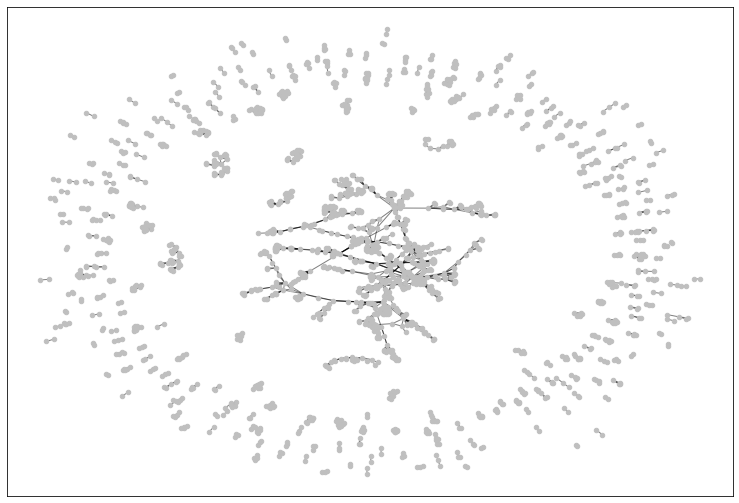

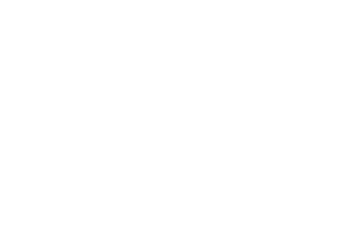

In [ ]:
bistaratu_grafoa(G)

## Helburu-funtzioa

1.fasean definitu genuen helburu funtzioa erabiliko dugu, modularitatea. Modularitateak sare baten komunitate banaketaren egokitasuna neurtzen du. Banaketa egokia izango da komunitateen barruan ertz asko badaude, eta komunitate artean gutxi.

### Sasikodea

> **Input:**
>
> $c$ : the partition of the nodes, a dictionary from nodes to communities
>
> $G$ : the graph, where $N(v)$ are neighbours of $v$ and $A_{vw}$ is the weight of the edge from $v$ to $v$
>    
> **Output:** $Q$ : modularity
>
> 1: $e, a = [], []$
>
> 2: $m = \frac{1}{2}\sum_{vw}A_{vw}$
>
> 3: $Q = 0$
>
> 4: **for** $v \in G$ **do**
>
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $i = c_v$
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k_v = \sum_{w}A_{vw}$
> 
> 7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $a_i = a_i + k_v$
>
> 8: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **for** $w \in N(v)$ **do**
>
> 9: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $e_{ii} = e_{ii} + A_{vw}\delta(c_v,c_w)$
>
> 10: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end for**
>
> 11: **end for**
>
> 12: **for** $i \in \{1,...,k\}$ **do**
>
> 13: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $Q = Q + (e_{ii}/2m - (a_i/2m)^2)$
>
> 14: **end for**

### Kodea

In [ ]:
from collections import defaultdict
def modularity(G, partition, weight='weight'):
    weights = defaultdict(int)
    degrees = defaultdict(int)
    sum = G.size(weight=weight)
    modularity = 0

    for node in G:
        community = partition[node]
        degrees[community] += G.degree(node, weight=weight)
        for neighbour, data in G[node].items():
            if partition[neighbour] == community:
                if neighbour == node: # 4 nodes have self edges
                    weights[community] += data[weight] * 2
                else:
                    weights[community] += data[weight]

    for community in set(partition.values()):
        modularity += (weights[community] / (2 * sum)) - (degrees[community] / (2 * sum)) ** 2
    return modularity

## Random Search

Hasteko, ausazko bilaketa inplementatuko dugu baseline edo oinarri-lerro moduan erabiltzeko. Horrela, inplementatzen ditugun beste algoritmoak konparatu ditzakegu.

In [ ]:
def random_search(G, max_evals, com_count):
    size = G.number_of_nodes()
    best_solution = list(np.random.randint(com_count, size=size))
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    for i in range(max_evals-1):
        solution = list(np.random.randint(com_count, size=size))
        partition = dict(zip(G.nodes, best_solution))
        fitness = modularity(G, best_partition)
        if fitness > best_fitness:
            best_fitness = fitness
            best_solution = solution
    return (best_fitness, best_solution, max_evals)

## Metodo Eraikitzailea

Bi algoritmoen hasieraketarako metodo eraikitzaile estokastikoa erabili dugu. Jadanik existitzen diren metodoetako batzuk konparatu ditugu. Gure ustez egokiena dena aukeratu dugu eta aldaketa batzuk egin ditugu problema honetara egokitzeko.

### Aukeraketa

Metodoa aukeratzeko CDLib [1] liburutegiko [2] hainbat metodo probatu ditugu. Denbora, modularitatea eta komunitate kopurua kontuan hartu ditugu. Louvain aukeratu dugu modularitate onena lortzen duelako denbora gutxian eta sinplea delako. Leiden azkarragoa da, baina konplexuagoa da eta kodea C++ lengoaian [3] bakarrik aurkitu dugu. Beraz, Louvain moldatzea errazagoa izango da.

[1] Rossetti, G., Milli, L. & Cazabet, R. [CDLIB: a python library to extract, compare and evaluate communities from complex networks](https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0165-9
). Appl Netw Sci 4, 52 (2019).

[2] CDlib - Community Discovery Library https://cdlib.readthedocs.io/en/latest/

[3] Implementation of the Leiden algorithm for various quality functions to be used with igraph in Python https://github.com/vtraag/leidenalg

In [ ]:
!pip install cdlib
!pip install python-igraph
!pip install leidenalg
from cdlib import algorithms
from timeit import default_timer

     |████████████████████████████████| 153kB 14.4MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 40.6MB 97kB/s 
     |████████████████████████████████| 1.8MB 48.5MB/s 
     |████████████████████████████████| 24.2MB 1.5MB/s 
  Created wheel for python-louvain: filename=python_louvain-0.14-cp37-none-any.whl size=9292 sha256=b4d117d26b560440b09dc33ebe60159dc00054cc0c97a1357127feac8f085dd9
  Stored in directory: /root/.cache/pip/wheels/e7/8d/24/6b3a464bb23e96ecba3f68868e85721534fd8158a9cd7b426b
  Created wheel for karateclub: filename=karateclub-1.0.24-cp37-none-any.whl size=94202 sha256=2919aa066cc507bb9971cc7bb30a0f45dff8ed4b1533d5c0afb345dd140c9244
  Stored in directory: /root/.cache/pip/wheels/ab/a4/81/a2761ff51bb1caa318e69e4a30f5d7d39c14f10efe73365279
Successfully built python-louvain karateclub
  Found existing installation: python-louvain 0.15
    Uninstalling python-louvain-0.15:
      Successfully uninstalled python-louvain-0.15

     |████████████████████████████████| 3.2MB 20.8MB/s 
     |████████████████████████████████| 2.4MB 16.8MB/s 


In [ ]:
def test_algorithm(method, **kwargs):
    start = default_timer()
    com = method(G, **kwargs)
    end = default_timer()
    partition = {key: value[0] for key, value in com.to_node_community_map().items()}
    com_count = len(set(list(partition.values())))
    print("Denbora:", end - start)
    print("Modularitatea:", com.newman_girvan_modularity().score)
    print("Komunitateak:", com_count)

#### AGDL

[1] Zhang, W., Wang, X., Zhao, D., & Tang, X. (2012, October). [Graph degree linkage: Agglomerative clustering on a directed graph](https://link.springer.com/chapter/10.1007/978-3-642-33718-5_31). In European Conference on Computer Vision (pp. 428-441). Springer, Berlin, Heidelberg.

In [ ]:
test_algorithm(algorithms.agdl, number_communities=291, kc=10)

Denbora: 4.773241313999989
Modularitatea: 0.9684210220918499
Komunitateak: 291


#### Louvain

[1] Blondel, Vincent D., et al. [Fast unfolding of communities in large networks](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008). Journal of statistical mechanics: theory and experiment 2008.10 (2008): P10008.


<figure>
    <img src='https://drive.google.com/uc?export=view&id=1Io2J3mHJ-mFTYVk0XDMkbeBsfpcrStOf' alt='Louvain' />
    <figcaption><b>1. Irudia.</b> Algoritmoaren pausuen ikustaratzea. Iterazio bakoitzak bi fase ditu: batean komunitateen aldaketa lokala bakarrik baimenduta modularitatea optimizatzen saiatzen da eta bestean, aurkitutako komunitateak agregatzen dira komunitateen sare berri bat sortzeko. Iterazio hauek modularitatea hobetzea posible ez den arte errepikatzen dira.</figcaption>
</figure>

In [ ]:
test_algorithm(algorithms.louvain)

Denbora: 0.3049737660000176
Modularitatea: 0.9722637390442146
Komunitateak: 291


#### Leiden

[1] Traag, V.A., Waltman, L. & van Eck, N.J. [From Louvain to Leiden: guaranteeing well-connected communities](https://www.nature.com/articles/s41598-019-41695-z). Sci Rep 9, 5233 (2019).

<figure>
    <img src='https://drive.google.com/uc?export=view&id=1KotmWxIHsHW57-Nx6muiFtSYh4-wlUXR' alt='Leiden' />
    <figcaption><b>Figure 2.</b> Leiden algorithm. The Leiden algorithm starts from a singleton partition (a). The algorithm moves individual nodes from one community to another to find a partition (b), which is then refined (c). An aggregate network (d) is created based on the refined partition, using the non-refined partition to create an initial partition for the aggregate network. For example, the red community in (b) is refined into two subcommunities in (c), which after aggregation become two separate nodes in (d), both belonging to the same community. The algorithm then moves individual nodes in the aggregate network (e). In this case, refinement does not change the partition (f). These steps are repeated until no further improvements can be made.</figcaption>
</figure>

In [ ]:
test_algorithm(algorithms.leiden)

Denbora: 0.0455581140000163
Modularitatea: 0.9703494703009221
Komunitateak: 291


### Sasikodea

#### Louvain

http://www.ijcee.org/vol8/927-A023.pdf

https://link.springer.com/content/pdf/10.1007/s13278-020-00641-y.pdf

### Inplementazioa

Metodo eraikitzaile estokastikoa inplementatzeko Louvain Heuristikoan oinarritu gara [1].  Community liburutegiko [2] inplementazioa hartu dugu GitHub-etik [3] eta hainbat funtzio moldatu ditugu gure beharretara.

[1] Blondel, Vincent D., et al. [Fast unfolding of communities in large networks. Journal of statistical mechanics](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008): theory and experiment 2008.10 (2008): P10008.

[2] Community detection for NetworkX’s documentation https://python-louvain.readthedocs.io/en/latest/

[3] Louvain Community Detection https://github.com/taynaud/python-louvain

#### Status

Community moduluak Status klaseako objektuak erabiltzen ditu kalkuluak egiterakoan egoera gerdetzeko. Honekin algoritmoa azkarragoa izatea lortzen da. Atal honetan aldaketa txikiak bakarrik egin ditugu. Adibidez, `dict([])` ordez `defaultdict(int)` erabili dugu adierazpen batzuk sinplifikatzeko.

In [ ]:
class Status(object):
    """
    To handle several data in one struct.
    Could be replaced by named tuple, but don't want to depend on python 2.6
    """
    node2com = {}
    total_weight = 0
    internals = {}
    degrees = {}
    gdegrees = {}

    def __init__(self):
        self.node2com = defaultdict(int)
        self.total_weight = 0
        self.degrees = defaultdict(int)
        self.gdegrees = defaultdict(int)
        self.internals = defaultdict(int)
        self.loops = defaultdict(int)

    def __str__(self):
        return ("node2com : " + str(self.node2com) + " degrees : "
                + str(self.degrees) + " internals : " + str(self.internals)
                + " total_weight : " + str(self.total_weight))

    def copy(self):
        """Perform a deep copy of status"""
        new_status = Status()
        new_status.node2com = self.node2com.copy()
        new_status.internals = self.internals.copy()
        new_status.degrees = self.degrees.copy()
        new_status.gdegrees = self.gdegrees.copy()
        new_status.total_weight = self.total_weight

    def init(self, graph, weight, part=None):
        """Initialize the status of a graph with every node in one community"""
        count = 0
        self.node2com = defaultdict(int)
        self.total_weight = 0
        self.degrees = defaultdict(int)
        self.gdegrees = defaultdict(int)
        self.internals = defaultdict(int)
        self.total_weight = graph.size(weight=weight)
        if part is None:
            for node in graph.nodes():
                self.node2com[node] = count
                deg = float(graph.degree(node, weight=weight))
                if deg < 0:
                    error = "Bad node degree ({})".format(deg)
                    raise ValueError(error)
                self.degrees[count] = deg
                self.gdegrees[node] = deg
                edge_data = graph.get_edge_data(node, node, default={weight: 0})
                self.loops[node] = float(edge_data.get(weight, 1))
                self.internals[count] = self.loops[node]
                count += 1
        else:
            for node in graph.nodes():
                com = part[node]
                self.node2com[node] = com
                deg = float(graph.degree(node, weight=weight))
                self.degrees[com] += deg
                self.gdegrees[node] = deg
                inc = 0.
                for neighbor, datas in graph[node].items():
                    edge_weight = datas[weight]
                    if edge_weight <= 0:
                        error = "Bad graph type ({})".format(type(graph))
                        raise ValueError(error)
                    if part[neighbor] == com:
                        if neighbor == node:
                            inc += float(edge_weight) * 2
                        else:
                            inc += float(edge_weight)
                self.internals[com] += inc

#### Louvain

Community moduluak Louvain algoritmoa erabiltzen du partizio onena kalkulatzeko, hau da, modularitate maximoa duena.

In [ ]:
import numbers
import networkx as nx
import numpy as np


def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance.
    Parameters
    ----------
    seed : None | int | instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (numbers.Integral, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError("%r cannot be used to seed a numpy.random.RandomState"
                     " instance" % seed)


def partition_at_level(dendrogram, level):
    """Return the partition of the nodes at the given level
    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities,
    and the best is len(dendrogram) - 1.
    The higher the level is, the bigger are the communities
    Parameters
    ----------
    dendrogram : list of dict
       a list of partitions, ie dictionnaries where keys of the i+1 are the
       values of the i.
    level : int
       the level which belongs to [0..len(dendrogram)-1]
    Returns
    -------
    partition : dictionnary
       A dictionary where keys are the nodes and the values are the set it
       belongs to
    """
    partition = dendrogram[0].copy()
    for index in range(1, level + 1):
        for node, community in partition.items():
            partition[node] = dendrogram[index][community]
    return partition


def best_partition(graph, com_count, level=3, min=0.0000001, partition=None, weight='weight', resolution=1., random_state=None):
    """Compute the partition of the graph nodes which maximises the modularity
    (or try..) using the Louvain heuristices
    This is the partition of highest modularity, i.e. the highest partition
    of the dendrogram generated by the Louvain algorithm.
    Parameters
    ----------
    graph : networkx.Graph
       the networkx graph which is decomposed
    com_count : int
       the number of communities
    level : int, optional
       the maximum level of the dendogram
    min : float, optional
       the minimum modularity improvement
    partition : dict, optional
       the algorithm will start using this partition of the nodes.
       It's a dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    Returns
    -------
    partition : dictionary
       The partition, with communities numbered from 0 to number of communities
    """
    dendo = generate_dendrogram(graph, com_count, level, min, partition, weight, resolution, random_state)
    return partition_at_level(dendo, len(dendo) - 1)


def best_fixed_partition(graph, com_count, level=3, min=0.0000001, partition=None, weight='weight', resolution=1., random_state=None):
    """Compute the partition of the graph nodes which maximises the modularity
    (or try..) using the Louvain heuristices
    This is the partition of highest modularity, i.e. the highest partition
    of the dendrogram generated by the Louvain algorithm.
    Parameters
    ----------
    graph : networkx.Graph
       the networkx graph which is decomposed
    com_count : int
       the number of communities
    level : int, optional
       the maximum level of the dendogram
    min : float, optional
       the minimum modularity improvement
    partition : dict, optional
       the algorithm will start using this partition of the nodes.
       It's a dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    Returns
    -------
    partition : dictionary
       The partition, with communities numbered from 0 to number of communities
    """
    original_partition = best_partition(graph, com_count, level, min, partition, weight, resolution, random_state)
    count = len(set(original_partition.values()))
    count_list=[]
    for i in range(count):
        count_list.append(list(original_partition.values()).count(i));
    indices = sorted(range(len(count_list)), key=lambda k: count_list[k])
    split = count-com_count
    indices = indices[:split]
    best_modul = 0
    if com_count < count:
        '''com_values = random.sample(range(count), com_count)'''
        com_values = list(range(com_count))
        com_values = list(set(original_partition.values()) - set(indices))
        for i in com_values:
            partition = original_partition.copy()
            for key, value in partition.items():
                if value not in com_values:
                    partition[key] = i
            modul = modularity(graph, partition)
            if modul > best_modul:
                best_modul = modul
                best_part = partition.copy()
    best_part = __renumber(best_part)
    return best_part


def generate_dendrogram(graph, com_count, level=3, min=0.0000001, part_init=None, weight='weight', resolution=1., random_state=None):
    """Find communities in the graph and return the associated dendrogram
    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities,
    and the best is len(dendrogram) - 1. The higher the level is, the bigger
    are the communities
    Parameters
    ----------
    graph : networkx.Graph
        the networkx graph which will be decomposed
    com_count : int
       the number of communities
    level : int, optional
       the maximum level of the dendogram
    min : float, optional
       the minimum modularity improvement
    part_init : dict, optional
        the algorithm will start using this partition of the nodes. It's a
        dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona
    Returns
    -------
    dendrogram : list of dictionaries
        a list of partitions, ie dictionnaries where keys of the i+1 are the
        values of the i. and where keys of the first are the nodes of graph
    """
    random_state = check_random_state(random_state)

    current_graph = graph.copy()
    status = Status()
    status.init(current_graph, weight, part_init)
    status_list = list()
    lvl = 0
    unique_values = set()
    while lvl <= level and len(unique_values) != com_count:
        __one_level(current_graph, com_count, min, status, weight, resolution, random_state)
        partition = __renumber(status.node2com)
        unique_values = set(partition.values())
        status_list.append(partition)
        current_graph = induced_graph(partition, current_graph, weight)
        status.init(current_graph, weight)
        lvl += 1
    return status_list[:]


def induced_graph(partition, graph, weight="weight"):
    """Produce the graph where nodes are the communities
    there is a link of weight w between communities if the sum of the weights
    of the links between their elements is w
    Parameters
    ----------
    partition : dict
       a dictionary where keys are graph nodes and  values the part the node
       belongs to
    graph : networkx.Graph
        the initial graph
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    Returns
    -------
    g : networkx.Graph
       a networkx graph where nodes are the parts
    """
    ret = nx.Graph()
    ret.add_nodes_from(partition.values())

    for node1, node2, datas in graph.edges(data=True):
        edge_weight = datas[weight]
        com1 = partition[node1]
        com2 = partition[node2]
        w_prec = ret.get_edge_data(com1, com2, {weight: 0}).get(weight, 1)
        ret.add_edge(com1, com2, **{weight: w_prec + edge_weight})

    return ret


def __renumber(dictionary):
    """Renumber the values of the dictionary from 0 to n
    """
    values = np.array(list(dictionary.values()))
    values += len(values) + 1
    search_list = []
    solution_list = np.zeros((len(values) + 1), dtype=int)
    n = 0
    for val in values:
        if val not in search_list:
            index_list = [i for i, e in enumerate(values) if e == val]
            for j in index_list:
                solution_list[j] = n
            search_list.append(val)
            n += 1
    ret = dict(zip(dictionary.keys(), solution_list))
    return ret


def __one_level(graph, com_count, min, status, weight_key, resolution, random_state):
    """Compute one level of communities
    """
    modified = True
    cur_mod = __modularity(status, resolution)
    new_mod = cur_mod
    while modified and len(status.node2com) != com_count:
        cur_mod = new_mod
        modified = False
        for node in __randomize(graph.nodes(), random_state):
            com_node = status.node2com[node]
            degc_totw = status.gdegrees.get(node, 0.) / (status.total_weight * 2.)
            neigh_communities = __neighcom(node, graph, status, weight_key)
            remove_cost = - resolution * neigh_communities.get(com_node,0) + \
                (status.degrees.get(com_node, 0.) - status.gdegrees.get(node, 0.)) * degc_totw
            __remove(node, com_node,
                     neigh_communities.get(com_node, 0.), status)
            best_com = com_node
            best_increase = float('-inf')
            for com, dnc in __randomize(neigh_communities.items(), random_state):
                incr = remove_cost + resolution * dnc - status.degrees[com] * degc_totw
                if incr > best_increase:
                    best_increase = incr
                    best_com = com
            __insert(node, best_com, neigh_communities[best_com], status)
            if best_com != com_node:
                modified = True
                if len(status.node2com) == com_count:
                    break
        new_mod = __modularity(status, resolution)
        if new_mod - cur_mod < min :
            break


def __neighcom(node, graph, status, weight_key):
    """
    Compute the communities in the neighborhood of node in the graph given
    with the decomposition node2com
    """
    weights = defaultdict(int)
    for neighbor, datas in graph[node].items():
        if neighbor != node:
            neighborcom = status.node2com[neighbor]
            weights[neighborcom] += datas[weight_key]
    return weights


def __remove(node, com, weight, status):
    """ Remove node from community com and modify status"""
    status.degrees[com] -= status.gdegrees[node]
    status.internals[com] -= weight + status.loops[node]
    status.node2com[node] = -1


def __insert(node, com, weight, status):
    """ Insert node into community and modify status"""
    status.node2com[node] = com
    status.degrees[com] += status.gdegrees[node]
    status.internals[com] += weight + status.loops[node]


def __modularity(status, resolution):
    """
    Fast compute the modularity of the partition of the graph using
    status precomputed
    """
    links = float(status.total_weight)
    result = 0.
    for community in set(status.node2com.values()):
        in_degree = status.internals[community]
        degree = status.degrees[community]
        if links > 0:
            result += in_degree * resolution / (2 * links) -  ((degree / (2. * links)) ** 2)
    return result


def __randomize(items, random_state):
    """Returns a List containing a random permutation of items"""
    randomized_items = list(items)
    random_state.shuffle(randomized_items)
    return randomized_items

### Konparazioa

Gure inplementazioa eta emaitzak community modulukoarekin konparatzen ditugu, egindako aldaketak hobeto ulertu ahal izateko.

#### Random State

Ausazko egoera hasieratzen dugu emaitzak erreproduzitu ahal izateko.

In [ ]:
import random
import numpy as np
random.seed(0)
np.random.seed(0)
rs = np.random.RandomState(0)

#### Generate Dendogram

Community moduluko `generate_dendogram` funtzioak komunitateak elkartzen ditu bakarrik hobetzen bada. Beraz, komunitate kopuru optimora iritsitakoan gelditu egiten da. Guri interesatzen zaigu emandako komunitate kopurua izatea, ez optimoa. 

Beraz, helburuko komunitate kopurura iritsitakoan algoritmoa geratzen dugu. Gainera, aldaketa batzuk egin ditugu komunitate kopurua gehiago jaitsi ahal izateko modularitatea asko txartu gabe. Horrela, `292` komunitate ingurutik `279` komunitate ingurura jaistea lortzen dugu.

Hala ere, honek ez du balio emandako komunitate kopurua `279` baino txikiagoa bada. Izan ere, komunitateen artean ertzik ez dagoenean algoritmoa geratu egiten da. Hurrengo atalean komentatuko dugu nola lortu dugun txikitzea.

In [ ]:
def print_levels(dendo):
    for level in range(len(dendo)):
        partition = partition_at_level(dendo, level)
        com_count = len(set(partition.values()))
        modul = modularity(G, partition)
        print("level", level, "com_count", com_count, "modularity", modul)

In [ ]:
dendo = community.generate_dendrogram(G, random_state=rs)
print_levels(dendo)

level 0 com_count 505 modularity 0.8177463819070343
level 1 com_count 310 modularity 0.962566741560396
level 2 com_count 292 modularity 0.9722773464278017


In [ ]:
dendo = generate_dendrogram(G, 50, random_state=rs)
print_levels(dendo)

level 0 com_count 505 modularity 0.8106948150719792
level 1 com_count 313 modularity 0.9587657866081087
level 2 com_count 284 modularity 0.9694273555320813
level 3 com_count 278 modularity 0.9457351027345177


#### Best Partition

Community moduluko `best_partition` edo gurea erabiltzen badugu antzeko arazoa daukagu, komunitate kopurua ezin da nahi adina jaitsi. Hori konpontzeko, `best_fixed_partition` funtzioa inplementatu dugu. Honek lehenengo aurreko funtzioari deituko dio. Gero, soberan geratzen diren komunitate guztiak komunitate berean elkartuko ditu. Izan ere, komunitateen artean konexiorik ez dagoenean, modularitate hobea lortzen da soberan dauden guztiak elkarrekin jarrita. Komunitatea aukeratzeko aukera guztiak aztertu eta onena aukeratzen da.

Funtzio hauei 3 parametro gehitu dizkiegu: `com_count`, `level` eta `min`. Hauekin komunitate kopurua, dendogramaren maila maximoa eta modularitatearen hobekuntza minimoa kontrola daiteke. Ikus daiteke komunitate kopurua nahi adina gutxitu daitekeela, eta modularitatea ez dela horrenbeste jaisten.

In [ ]:
def print_partition(partition):
    com_count = len(set(partition.values()))
    modul = modul = modularity(G, partition)
    print("com_count", com_count, "modularity", modul)

In [ ]:
best_part_com = community.best_partition(G, random_state=rs)
print_partition(best_part_com)

com_count 291 modularity 0.9719956368108386


In [ ]:
best_part = best_partition(G, 50, random_state=rs)
print_partition(best_part)

com_count 279 modularity 0.9603208285973075


In [ ]:
best_fixed_part = best_fixed_partition(G, 50, random_state=rs)
print_partition(best_fixed_part)

com_count 50 modularity 0.9064209606338802


#### Induced Graph

Aurreko partizioak grafo moduan bistaratu ditzakegu aldea hobeto ikusteko.

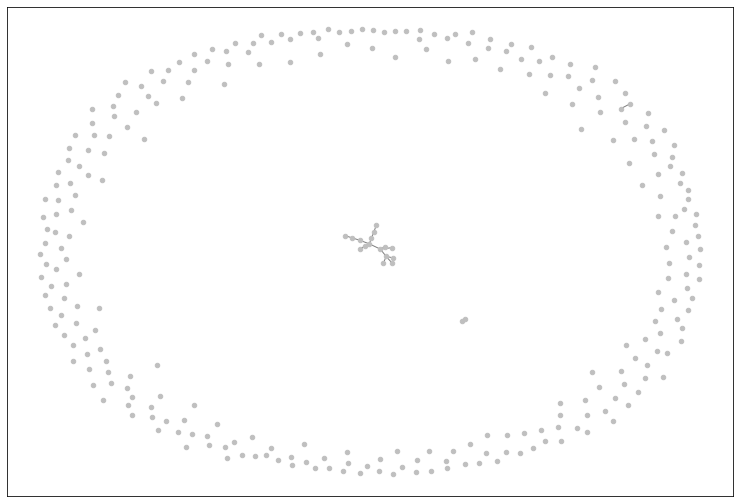

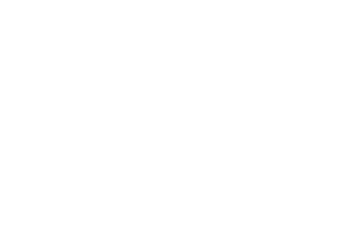

In [ ]:
graph_com = community.induced_graph(best_part_com, G)
bistaratu_grafoa(graph_com)

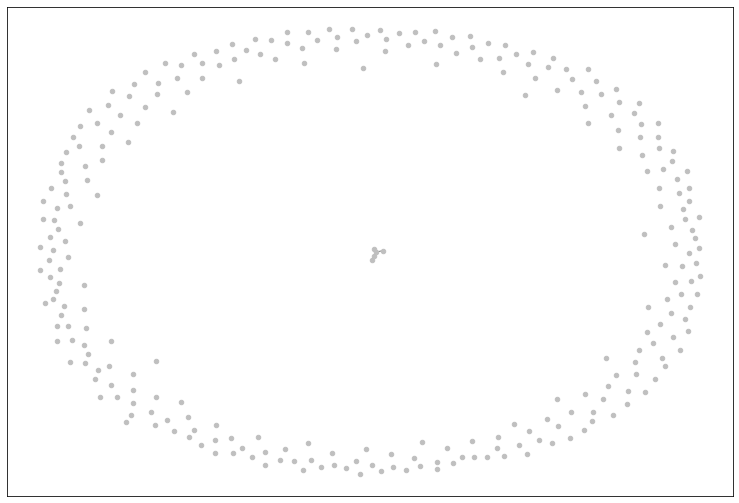

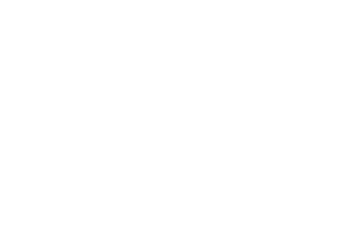

In [ ]:
graph = induced_graph(best_part, G)
bistaratu_grafoa(graph)

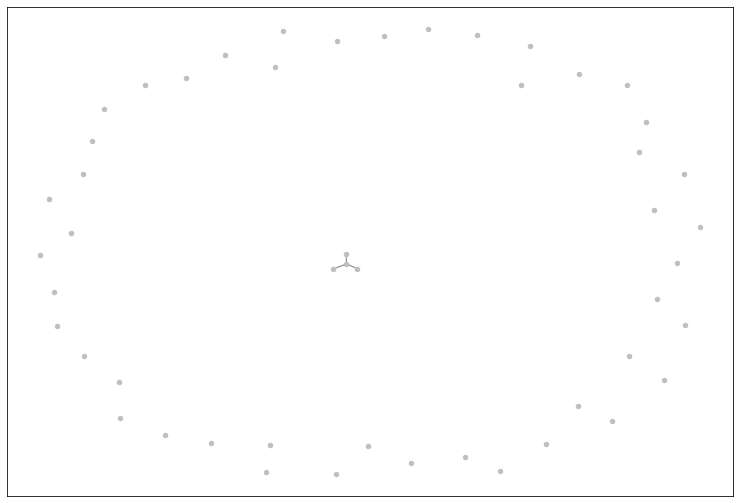

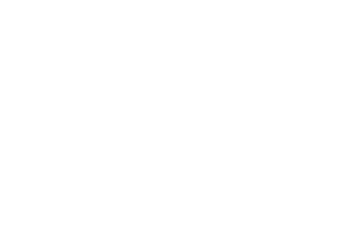

In [ ]:
graph_fixed = induced_graph(best_fixed_part, G)
bistaratu_grafoa(graph_fixed)

## 1. ILS

community detection local search https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=community+detection+local+search&oq=com

An evolutionary method for community detection using a novel local search strategy https://www.sciencedirect.com/science/article/pii/S0378437119301402

An iterated local search algorithm for community detection in complex networks https://www.worldscientific.com/doi/abs/10.1142/S0217979220500137

A novel iterated greedy algorithm for detecting communities in complex network https://link.springer.com/content/pdf/10.1007/s13278-020-00641-y.pdf

### Diseinua

#### ILS

![ILS](https://drive.google.com/uc?export=view&id=1ItmPvyTUC_ThfOqLzg4mj8MzFG7RsTXU)

### Sasikodea

#### LS

> **Input:** $f$ helburu-funtzioa, $s_0$ hasierako soluzioa eta
>
> $N$ ingurune funtzioa
> 
> **Output:** $s^*$ soluzioa
> 
> 1: $s^* = s_0$
> 
> 2: **repeat**
> 
> 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $H = \{s^´ \in N(s^*) | f(s^´) > f(^*)\}$
>
> 4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $|H|>0$ **then**
>
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Aukeratu $H$-n dagoen soluzio bat $s^´$
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^* = s^´$
>
> 7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end**
>
> 8: **until** $s^*$ aldatu da

#### ILS

> **Input:** $local\_search$ bilaketa algoritmoa, $perturbation$ perturbazioa eta
>
> $stop\_criterion$ gelditzeko irizpidea
> 
> **Output:** $s^*$ soluzioa
> 
> 1: **repeat**
> 
> 2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^* = perturbation(s^*)$
>
> 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s = local\_search(s^*)$
>
> 4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $f(s) > f(s^*)$ **then**
>
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^* = s$
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end**
>
> 7: **until** $!stop\_criterion()$

### Local Search

#### Swap

In [ ]:
def swap(solution, i, j):
    solution[i], solution[j] = solution[j], solution[i]
    return solution

def swap_neighbours(solution):
    neighbours = []
    size = len(solution)
    for i in range(size):
        for j in range(i+1, size):
            neighbours.append(swap(solution[:], i, j))
    return neighbours

def best_first_swap(G, best_solution, best_fitness, evals, max_evals):
    improve = False
    size = len(best_solution)
    for i in range(size):
        for j in range(i+1, size):
            solution = swap(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
    return (best_fitness, best_solution, evals, improve)

def local_search_swap(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count, random_state=rs)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_swap(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

In [ ]:
def local_search_swap(G, best_solution, evals, max_evals, com_count):
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    improve = True
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_swap(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

#### Insert

In [ ]:
def insert(solution, i, j):
    solution.insert(j, solution.pop(i))
    return solution

def insert_neighbours(solution):
    neighbours = []
    size = len(solution)
    for i in range(size):
        for j in list(range(0, i-1)) + list(range(i+1, size)):
            neighbours.append(insert(solution[:], i, j))
    return neighbours

def best_first_insert(G, best_solution, best_fitness, evals, max_evals):
    improve = False
    size = len(best_solution)
    for i in range(size):
        for j in list(range(0, i-1)) + list(range(i+1, size)):
            solution = insert(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
            print(evals)
    return (best_fitness, best_solution, evals, improve)

def local_search_insert(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count, random_state=rs)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_insert(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

In [ ]:
def local_search_insert(G, best_solution, evals, max_evals, com_count):
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    improve = True
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_insert(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

### Perturbazioa

In [ ]:
def perturbate_solution(best_solution, com_count):
    ci = random.randrange(com_count)
    cj = random.randrange(com_count)
    ck = random.randrange(com_count)
    while best_solution.count(ck) < 2:
        ck = random.randrange(com_count)
    solution = merge(best_solution, ci, cj)
    solution = split(solution, ck)
    return solution

#### Merge

In [ ]:
def merge(solution, ci, cj):
    # solution[solution == cj] = ci
    size = len(solution)
    for i in range(size):
        if solution[i] == cj:
            solution[i] = ci
    return solution

def merge_neighbours(solution, com_count):
    neighbours = []
    for ci in range(com_count):
        for cj in range(ci + 1, com_count):
            neighbours.append(merge(solution[:], ci, cj))
    return neighbours

def greedy_merge(G, best_solution, best_fitness, evals, max_evals, com_count):
    best_fit = float('-inf')
    improve = False
    neighs = merge_neighbours(best_solution, com_count)
    for n in neighs:
        partition = dict(zip(G.nodes, n))
        fitness = modularity(G, partition)
        evals += 1
        if fitness > best_fit:
            print(n)
            best_solution = n
            best_fit = fitness
        if evals == max_evals:
            break
    if best_fit > best_fitness:
        improve = True
    best_fitness = best_fit
    return (best_fitness, best_solution, evals, improve)

def local_search_merge(G, max_evals, com_count):
    best_part = best_partition(G, com_count)
    best_solution = list(best_part.values())
    best_fitness = modularity(G, best_part)
    unique_values = set(best_solution)
    improve = True
    evals = 1
    while evals < max_evals and len(unique_values) > com_count:
        best_fitness, best_solution, evals, improve = greedy_merge(G, best_solution, best_fitness, evals, max_evals, com_count)
        unique_values = set(best_solution)
        print(len(unique_values), evals)
        
    return (best_fitness, best_solution, evals)

#### Split

In [ ]:
def split(solution, community):
    com_count = len(set(solution))
    indices = [index for index, element in enumerate(solution) if element == community]
    index = random.choice(indices)
    solution[index] = com_count
    indices.remove(index)
    index = random.choice(indices)
    indices.remove(index)
    for i in indices:
        random_bit = random.getrandbits(1)
        random_boolean = bool(random_bit)
        if random_boolean:
            solution[i] = com_count  
    return solution

### Simulated Annealing

In [ ]:
import random
import math

def initial_temperature(best_fitness):
    return 0.025 * best_fitness

def update_temperature(temp):
    return 0.9 * temp
    
def simmulated_annealing(best_solution, best_fitness, solution, fitness, temp):
    if fitness > best_fitness:
        best_solution = solution
        best_fitness = fitness
    else:
        p = random.uniform(0, 1)
        if p <= math.exp((fitness - best_fitness) / temp):
            best_solution = solution
            best_fitness = fitness
    temp = update_temperature(temp)
    return best_solution, best_fitness, temp

### Iterated Local Search

In [ ]:
def ILS(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count, random_state=rs)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    print(best_fitness)
    evals = 1
    while evals < max_evals:
        best_solution = perturbate_solution(best_solution, com_count)
        best_partition = dict(zip(G.nodes, best_solution))
        best_fitness = modularity(G, best_partition)
        print(best_fitness)
        fitness, solution, evals = local_search_swap(G, best_solution, evals, max_evals, com_count)
        print(fitness)
        if fitness > best_fitness:
            best_solution = solution
            best_fitness = fitness
    return (best_fitness, best_solution, evals)

### Multistart Local Search

In [ ]:
def MLS(G, max_evals, com_count):
    evals = 1
    while evals < max_evals:
        best_partition = best_fixed_partition(G, com_count, random_state=rs)
        best_solution = list(best_partition.values())
        best_fitness = modularity(G, best_partition)
        fitness, solution, evals = local_search_swap(G, best_solution, evals, max_evals, com_count)
        if fitness > best_fitness:
            best_solution = solution
            best_fitness = fitness

    return (best_fitness, best_solution, evals)

### Variable Neighbourhood Search

In [ ]:
def VNS(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count, random_state=rs)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals = local_search_swap(G, best_solution, evals, max_evals, com_count)
        print(evals)
        best_fitness, best_solution, evals, improve = best_first_insert(G, best_solution, best_fitness, evals, max_evals)
        print(evals)

    return (best_fitness, best_solution, evals)

### Exekutatu

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import time as tm

# Egin exekuzioak budget desberdinetarako: 10, 100, 1000, 10000...
def run_search(function, com_count, budget=5, repetitions=1):
    list_budget = []
    list_fit = []
    list_time = []
    for exp in range(1, budget):
        budget = 10 ** exp
        avg_fit = 0
        avg_time = 0
        for rep in tqdm(range(repetitions), position=0, leave=True):
            start = tm.time()
            (fitness, sol, evals) = function(G, budget, com_count)
            end = tm.time()
            avg_time += end - start
            avg_fit += fitness
        avg_fit = avg_fit / repetitions
        avg_time = avg_time / repetitions
        print()
        print("Budget:", budget, " Average fitness:", avg_fit, " Average time:", avg_time)
        list_budget.append(budget)
        list_fit.append(avg_fit)
        list_time.append(avg_time)
    return list_budget, list_fit, list_time

In [ ]:
list_budget, list_fit_rs, list_time_rs = run_search(random_search, 50)

In [ ]:
list_budget, list_fit_ls_swap, list_time_ls_swap = run_search(local_search_swap, 50)

In [ ]:
list_budget, list_fit_ls_ins, list_time_ls_ins = run_search(local_search_insert, 50)

In [ ]:
list_budget, list_fit_ils, list_time_ils = run_search(ILS, 50)

In [ ]:
list_budget, list_fit_sls, list_time_sls = run_search(MLS, 50)

  0%|          | 0/1 [00:00<?, ?it/s]


Budget: 10  Average fitness: 0.7979980228839416  Average time: 2.436241626739502


  0%|          | 0/1 [00:00<?, ?it/s]


Budget: 100  Average fitness: 0.8019663527406498  Average time: 4.2851927280426025


  0%|          | 0/1 [00:00<?, ?it/s]


Budget: 1000  Average fitness: 0.7975537193351687  Average time: 23.210510969161987


100%|██████████| 1/1 [03:29<00:00, 209.27s/it]


Budget: 10000  Average fitness: 0.797865340678215  Average time: 209.26925015449524


In [ ]:
list_budget, list_fit_vns, list_time_vns = run_search(VNS, 50)

  0%|          | 0/1 [00:00<?, ?it/s]

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
28

KeyboardInterrupt: ignored

In [ ]:
# Datuak gordetzeko egitura
datuak = pd.DataFrame({"n": list_budget, "RS": list_fit_rs, "LS Swap": list_fit_ls_swap, "LS Insert": list_fit_ls_ins, 
                       "ILS": list_fit_ils, "SLS": list_fit_sls, "VNS": list_fit_vns})
print(datuak)
print()

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line', x='n', y='RS', ax=ax, title='Algoritmoen Firness-ak')
datuak.plot(kind='line', x='n', y='LS Swap', ax=ax)
datuak.plot(kind='line', x='n', y='LS Insert', ax=ax)
datuak.plot(kind='line', x='n', y='ILS', ax=ax)
datuak.plot(kind='line', x='n', y='SLS', ax=ax)
datuak.plot(kind='line', x='n', y='VNS', ax=ax)
plt.show()

## 2. GA-EDA

community detection eda https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=community+detection+eda&btnG=

An EDA-based Community Detection in Complex
Networks http://webpages.iust.ac.ir/mozayani/Papers-pdf/ieee79189c24-5f04-20150417114429.pdf

The Improved Estimation of Distribution Algorithms for Community Detection https://ieeexplore.ieee.org/abstract/document/8711535

Community detection in the textile-related trade network using a biased estimation of distribution algorithm https://link.springer.com/content/pdf/10.1007/s12652-017-0489-1.pdf

A Method Towards Community Detection Based on Estimation of Distribution Algorithm https://link.springer.com/chapter/10.1007/978-3-319-68542-7_57

GA-EDA: Hybrid Evolutionary Algorithm Using Genetic and Estimation of Distribution Algorithms https://link.springer.com/chapter/10.1007/978-3-540-24677-0_38

https://medium.datadriveninvestor.com/population-initialization-in-genetic-algorithms-ddb037da6773

### Diseinua

#### Populazioak



Soluzio bakarrean oinarritutako algoritmoak

![Soluzio bakarra](https://drive.google.com/uc?export=view&id=1IWn8nDVbNDPBfUS0sntjpXkStxPsBzmg)

Populazioaetan oinarritutako algoritmoak

![Populazioak](https://drive.google.com/uc?export=view&id=1IWATIX65r4PRCkl5rsyixGs01KBG3SBo)

#### GA

Genetic Algorithm

![EDA](https://drive.google.com/uc?export=view&id=1M8wKqSHWo8Ra4fd-CZlvHOaTLHgDrPvn)

#### EDA

Estimation of Distribution Algorithm (EDA)

![EDA](https://drive.google.com/uc?export=view&id=1ILC5n5IYesrtbMsts6IUsP8zOvd4nBnp)

#### UMDA
 
Univariate Marginal Distribution Algorithm (UMDA)

![EDA](https://drive.google.com/uc?export=view&id=1ILZxrJgEhh4rp8Sp3gDRU_xNjlcgbcw4)

### Sasikodea

#### GA

> **Input:** $evaluate$, $select$, $reproduce$, $update$ eta
> 
> $stop\_criterion$ operadoreak, $P_0$ hasierako populazioa
> 
> 1: **Output:** $s^*$ soluzioa
> 
> 2: **while** $!stop\_criterion()$ **do**
> 
> 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $f_t = evaluate(P_t)$
> 
> 4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $P^s_t = select(P_t, f_t)$
> 
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $P^n_t = reproduce(P^s_t)$
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $P_{t+1} = update(P_t, P^n_t)$
>
> 7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $t = t + 1$
>
> 8: **end**
>
> 9: $s^* =$ Populazioko soluziorik onena



#### EDA

> **Input:** $evaluate$, $select$, $learn$, $sample$, $update$  eta
> 
> $stop\_criterion$ operadoreak, $P_0$ hasierako populazioa
> 
> **Output:** $s^*$ soluzioa
> 
> 1: **while** $!stop\_criterion()$ **do**
> 
> 2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $f_t = evaluate(P_t)$
> 
> 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $P^s_t = select(P_t, f_t)$
> 
> 4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $M_t = learn(P^s_t)$
>
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $P^n_t = sample(M_t)$
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $P_{t+1} = update(P_t, P^n_t)$
>
> 7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $t = t + 1$
>
> 8: **end**
>
> 9: $s^* =$ Populazioko soluziorik onena

#### GA-EDA

### Hasierako Populazioa

Hasierako populazioa eraiki behar dugu. Bi modu probatu ditugu, ausaz `random_population` eta moldatutako louvain heuristikoa erabiliz, `louvain_population`.

Ausaz hasieratuta, espero den bezela emaitzak txarrak dira. Hasierako soluzioak oso txarrak dira. Pixkanaka hobetzen joaten dira, baina oso txarrak izaten jarraitzen dute.

Louvain heuristikoa erabiltzen badugu, berriz, hasieratik dauzkagun soluzioak oso onak da. Hasierako iterazioaetan soluzioa okerragoak lortzen dira. Pixkanaka hobetzen joaten dira, eta iterazio asko egiten badira, hasierako soluzio onena lortzen da gehienez. Izan ere, oso zaila da soluzio oso onetik hasita hobetzea.

In [ ]:
com_count = 50
individuals = 50
count = int(individuals / 5)
tournament_size = int(individuals / 10)
size = G.number_of_nodes()

#### Random

In [ ]:
def random_population(individuals, size, com_count):
    population = np.zeros((individuals, size), dtype=int)
    for i in range(individuals):
        solution = np.random.randint(com_count, size=size)
        population[i] = solution
    return population

random_pop = random_population(individuals, size, com_count)
print(random_pop)

[[22  0 42 ... 11  3 13]
 [39 21 40 ...  4 39 22]
 [44 16 16 ... 44 41 28]
 ...
 [ 8 39 18 ...  2  8  6]
 [ 8 46 11 ... 14 45 36]
 [43 14 11 ... 15  2  2]]


#### Louvain

In [ ]:
from tqdm import tqdm
def louvain_population(individuals, size, com_count):
    population = np.zeros((individuals, size), dtype=int)
    for i in tqdm(range(individuals), position=0, leave=True):
        partition = best_fixed_partition(G, com_count, random_state=rs)
        solution = np.fromiter(partition.values(), dtype=int)
        population[i] = solution
    return population

louvain_pop = louvain_population(individuals, size, com_count)
print()
print(louvain_pop)

 28%|██▊       | 14/50 [00:30<01:18,  2.18s/it]

KeyboardInterrupt: ignored

### Soluzioak Ebaluatu

In [ ]:
def solution_modularity(G, solution):
    partition = dict(zip(G.nodes, solution))
    return modularity(G, partition)

def evaluate(population, evals):
    evaluation = []
    for solution in population:
        modularity = solution_modularity(G, solution)
        evaluation.append((modularity, solution))
        evals += 1
    return evaluation, evals

def print_evaluation(evaluation):
    sorted_evaluation = sorted(evaluation, key=lambda x: x[0], reverse=True)
    for sol in sorted_evaluation:
        print(sol[0])
    print()

evaluation, evals = evaluate(random_pop, 0)
print_evaluation(evaluation)

evaluation, evals = evaluate(louvain_pop, 0)
print_evaluation(evaluation)

0.008068851562977588
0.007169047999657404
0.006296500066524987
0.006152498805982738
0.0053096174208507926
0.00486510955700897
0.003586342403941679
0.003390240800836612
0.003017324937128168
0.002933228854779714
0.0028783498272802127
0.002865191936844741
0.0027046820187374893
0.002683801018698587
0.002518959621131212
0.002384806346908681
0.0022354520315619373
0.0020452755654542113
0.002010460277718117
0.00183307393492189
0.0016849863730021676
0.0016346022770178882
0.0016321504961914037
0.001611923304372897
0.001220986851589784
0.0012054997693691496
0.00098058974155288
0.0009349048921526993
0.0008552220152919197
0.00037867754865068587
0.0003582869047770818
0.00016565865784287024
0.00010791921937913795
-0.0005646042613258386
-0.0005711014805160257
-0.0009246891387090098
-0.0009829597963518168
-0.0011167044404366
-0.0011391790980127174
-0.0012591937694691841
-0.0012910260571997198
-0.001709871948390995
-0.001837936633561088
-0.0019016829350497109
-0.0024924395251913934
-0.002855343950525025

### Soluzioak Aukeratu

Soluzioak aukeratu behar ditugu eredua ikasteko. Horretarako, bi metodo probatu ditugu, select best eta tournament selection.

`best_selection` algoritmoa erabiltzen badugu, beti `count` soluzio onenak aukeratuko dira.

`tournament_selection` algoritmoak, berriz, ausazkotasuna dauka. `tournament_size` tamainako `count` txapelketa egiten dira. Txapelketako partaideak ausaz aukeratzen dira populazio osoa kontuan hartuz.

#### Best

In [ ]:
def best_selection(evaluation, count):
    individuals = len(evaluation)
    sorted_pop = sorted(evaluation, key=lambda x: x[0], reverse=True)
    best_sorted = sorted_pop[:count]
    return best_sorted

selected = best_selection(evaluation, count)
print_evaluation(selected)

0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8021202428505255
0.8021202428505255



#### Tournament

In [ ]:
def tournament_selection(evaluation, tournament_size, count):
    winners = []
    for i in range(count):
        solutions = random.choices(evaluation, k=tournament_size)
        sorted_sols = sorted(solutions, key=lambda x: x[0], reverse=True)
        winners.append(sorted_sols[0])
    sorted_winners = sorted(winners, key=lambda x: x[0], reverse=True)
    return sorted_winners

selected = tournament_selection(evaluation, tournament_size, count)
print_evaluation(selected)

0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8035493858942839
0.8021202428505255
0.8019663527406498
0.8017992638773248
0.8017992638773248
0.8017652249868504
0.7978566777192948



#### Roulette

In [ ]:
def roulette_selection(evaluation, count):
    size = len(evaluation)
    total_fitness = sum(solution[0] for solution in evaluation)
    distribution = np.zeros(size)
    for i, solution in enumerate(evaluation):
        for j in range(i, size):
            distribution[j] += solution[0] / total_fitness
    winners = []
    for i in range(count):
        r = random.uniform(0, 1)
        for j, p in enumerate(distribution):
            if p >= r:
                winners.append(evaluation[j])
                break
    sorted_winners = sorted(winners, key=lambda x: x[0], reverse=True)
    return sorted_winners

selected = roulette_selection(evaluation, count)
print_evaluation(selected)

0.8035493858942839
0.8017296333018527
0.8017296333018527
0.7999294132300057
0.797865340678215
0.7978566777192948
0.7964565474153165
0.7953552074680592
0.7900238100608664
0.7899038362524238



### EDA

#### Eredua Ikasi

Eredua ikasteak esan nahi du aukeratutako soluzioetatik probabilitate distribuzioa kalkulatzea.

Horretarako, populazioko soluzioen posizioa bakoitzean komunitate bakoitzaren probabilitatea kalkulatzen da, `get_distribution` funtzioan ikus daitekeen bezala.

Eredua lagintzeko probabilitate metatuak interesatzen zaizkigunez, aldaketa hori egiten dugu `cummulative_distribution` funtzioan.

In [ ]:
def get_distribution(selected, com_count, size):
    population = [sol[1] for sol in selected]
    individuals = len(population)
    distribution = np.zeros((com_count, size), dtype=float)
    for sol in population:
        for i, com in enumerate(sol):
            distribution[com, i] += 1 / individuals
    return distribution

distribution = get_distribution(selected, com_count, size)
print(distribution)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
def cummulative_distribution(selected, com_count, size):
    population = [sol[1] for sol in selected]
    individuals = len(population)
    distribution = np.zeros((com_count, size), dtype=float)
    for sol in population:
        for i, com in enumerate(sol):
            for j in range(com, com_count):
                distribution[j, i] += 1 / individuals
    return distribution
    
cum_distribution = cummulative_distribution(selected, com_count, size)
print(cum_distribution)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


#### Eredua Lagindu

Eredua lagintzeko ausazko zenbakiak kalkulatzen dira, eta probabilitate distribuzio metatua erabiliz, dagokion komunitatea aukeratzen da.

`generate_solution` metodoan aurreko pausoak jarraituz soluzio bat eraikitzen da.

`generate_population` metodoan aurreko algoritmoa hainbat aldiz errepikatzen da `individuals` soluzio eraiki arte.

In [ ]:
def generate_solution(distribution, individuals):
    com_count = distribution.shape[0]
    size = distribution.shape[1]
    solution = np.zeros(size, dtype=int)
    for i in range(size):
        r = random.uniform(0, 1)
        for j in range(com_count-1):
            if j == 0 and distribution[j][i] > r:
                solution[i] = j
                break
            elif distribution[j][i] <= r and distribution[j+1][i] > r:
                solution[i] = j+1
                break
    return solution

generated_solution = generate_solution(cum_distribution, individuals)
print(generated_solution)
print(solution_modularity(generated_solution))

[40 25  6 ... 27 25  5]
0.0031861709100454694


In [ ]:
def generate_population(distribution, individuals):
    com_count = distribution.shape[0]
    size = distribution.shape[1]
    population = np.zeros((individuals, size), dtype=int)
    for i in range(size):
        randoms = np.random.uniform(size=individuals)
        for k, r in enumerate(randoms):
            for j in range(com_count-1):
                if j == 0 and distribution[j][i] > r:
                    population[k][i] = j
                    break
                elif distribution[j][i] <= r and distribution[j+1][i] > r:
                    population[k][i] = j+1
                    break
    return population

generated_population = generate_population(cum_distribution, individuals)
print(generated_population)
print(solution_modularity(generated_population[0]))

[[18 43 21 ... 35 45 20]
 [26  8 45 ... 47 30 37]
 [40 31  7 ... 16 10 15]
 ...
 [ 7  8 18 ... 14 45 11]
 [11 27 40 ... 38 26 35]
 [ 8  8 25 ... 41  2 24]]
0.002602973977452116


### GA

#### Birkonbinazioa

#### Mutazioa

### Populazioa Eguneratu

#### Elitism

In [ ]:
def elitism_update(evaluation, new_evaluation):
    best = best_selection(evaluation, 1)
    evaluation = best + new_evaluation
    return evaluation

### GA

### UMDA

EDA exekutatzeko aurretik definitutako metodoak erabiltzen dira hainbat iteraziotan.

Hasteko, parametroak aukeratu behar ditugu:
* `com_count`: komunitate kopurua
* `individuals`: indibiduo kopurua
* `count`: aukeratutako soluzio kopurua
* `tournament_size`: txapelketa bakoitzaren tamaina

Ondoren, hasierako populazioa eraikitzen dugu. Horrekin hainbat iterazio egingo ditugu ebaluazio kopuru maximora iritsi arte.

Gero, aukeraketa egiten dugu `best_selection` edo `tournament_selection` erabiliz. Distribuzioa metatua kalkulatu ondoren populazio berria eraikitzen dugu. Aurreko populazioko soluzio onena gordetzen dugu eta hurrengo iteraziora pasatzen gara.



In [ ]:
com_count = 50
individuals = 50
count = int(individuals / 5)
tournament_size = int(individuals / 10)
def UMDA(G, max_evals, com_count, individuals, count, tournament_size):
    size = G.number_of_nodes()
    #population = louvain_population(individuals, size, com_count)
    population = random_population(individuals, size, com_count)
    evals, prev_evals = 0, 0
    evaluation, evals = evaluate(population, evals)
    print_evaluation(evaluation)
    pbar = tqdm(total=max_evals, position=0, leave=True)
    while evals < max_evals:
        selected = roulette_selection(evaluation, count)
        distribution = cummulative_distribution(selected, com_count, size)
        new_population = generate_population(distribution, individuals-1)
        new_evaluation, evals = evaluate(new_population, evals)
        evaluation = elitism_update(evaluation, new_evaluation)
        print_evaluation(evaluation)
        pbar.update(evals - prev_evals)
        prev_evals = evals
    pbar.close()

    sorted_evaluation = sorted(evaluation, key=lambda x: x[0], reverse=True)
    best_fitness = sorted_evaluation[0][0]
    best_solution = sorted_evaluation[0][1]
    return best_fitness, best_solution, evals

In [ ]:
best_fitness, best_solution, evals = UMDA(G, 10000, com_count, individuals, count, tournament_size)
print(best_fitness, best_solution)

  0%|          | 0/10000 [00:00<?, ?it/s]

(0.0056051795994836225, array([21, 24, 45, ..., 34, 42, 15]))
(0.005095781269767482, array([48, 36, 13, ...,  7, 14, 19]))
(0.004639872625082502, array([45, 49,  7, ..., 17,  8,  0]))
(0.004456397693233836, array([ 3, 31, 43, ...,  3, 29,  4]))
(0.004219555665395338, array([41, 39, 28, ..., 19, 20, 24]))
(0.003794212555013873, array([20, 43, 24, ..., 25, 28, 21]))
(0.003675015143832902, array([16, 11, 31, ...,  9, 13, 45]))
(0.003370912595321152, array([ 1, 11, 32, ...,  5,  3, 41]))
(0.0033472937733593426, array([43, 42, 34, ...,  0, 10, 35]))
(0.0032152653758530957, array([47, 38, 12, ..., 12, 40, 48]))
(0.0031225063345843955, array([47, 21, 21, ..., 13, 26, 45]))
(0.002883212525919409, array([31, 38, 40, ..., 14, 11, 32]))
(0.0028623315258805076, array([ 0, 12, 40, ...,  3, 27, 49]))
(0.002432084853846075, array([ 0, 30, 49, ..., 35,  5, 12]))
(0.0022778678398601374, array([ 7, 21,  8, ..., 30,  2, 44]))
(0.0022184121548178637, array([19, 16, 32, ..., 21, 19, 41]))
(0.00217677274378

  1%|          | 99/10000 [00:03<05:32, 29.82it/s]

(0.00702087871171013, array([31, 30, 34, ..., 19, 11, 45]))
(0.006433718066780623, array([16, 38, 13, ...,  7, 20, 48]))
(0.0056051795994836225, array([21, 24, 45, ..., 34, 42, 15]))
(0.0050616606532655605, array([16, 38, 31, ..., 12, 26, 19]))
(0.004697080844367162, array([31, 11, 40, ...,  9, 14, 48]))
(0.004472089090523345, array([ 0, 36, 34, ...,  7, 14, 12]))
(0.004051853856863728, array([43, 21, 21, ..., 14, 40, 32]))
(0.00391533052784226, array([43, 21, 34, ..., 14, 26, 48]))
(0.003725930458996253, array([47, 38, 21, ...,  0, 11, 19]))
(0.003577148225842358, array([ 0, 11, 13, ..., 13, 20, 45]))
(0.0035258242805412615, array([31, 36, 28, ..., 14, 11, 45]))
(0.0034959125544581386, array([16, 38, 28, ...,  9, 10, 32]))
(0.003489333609240401, array([47, 30, 49, ..., 14, 11, 32]))
(0.003361350650097859, array([47, 11, 49, ..., 35, 13, 45]))
(0.0032379034854843128, array([16, 38, 49, ..., 14, 13, 32]))
(0.002698348251602403, array([48, 38, 31, ...,  9,  5, 45]))
(0.002105507647758207

  1%|▏         | 148/10000 [00:06<07:07, 23.06it/s]

(0.00702087871171013, array([31, 30, 34, ..., 19, 11, 45]))
(0.0059108758055325915, array([31, 36, 45, ..., 14, 13, 45]))
(0.005861022928727387, array([ 0, 11, 34, ..., 14, 26, 45]))
(0.005534282270584416, array([43, 36, 34, ..., 14, 26, 19]))
(0.005153438982203669, array([ 0, 36, 31, ..., 34, 42, 12]))
(0.004926567529726207, array([ 0, 38, 49, ...,  9, 26, 48]))
(0.004208236610579726, array([47, 11, 21, ..., 14, 14, 15]))
(0.0040803762404785105, array([43, 38, 34, ..., 14, 11, 12]))
(0.0038844380894285436, array([21, 11, 28, ..., 14, 13, 45]))
(0.0036680684314911965, array([47, 36, 34, ..., 12, 26, 19]))
(0.0035887941847681645, array([47, 36, 31, ..., 14, 13, 15]))
(0.0035331796230207184, array([31, 21, 45, ..., 14, 14, 15]))
(0.0033627808555799733, array([16, 38, 45, ..., 14, 26, 45]))
(0.00314951678668951, array([47, 11, 45, ...,  7, 13, 48]))
(0.003053611293360151, array([16, 21, 45, ...,  9, 42, 45]))
(0.002728995511933472, array([ 0, 36, 49, ...,  7, 26, 19]))
(0.0027139170598505

  2%|▏         | 197/10000 [00:09<08:13, 19.86it/s]

(0.008850315838406064, array([16, 36, 34, ..., 14, 42, 48]))
(0.00807755538491161, array([21, 21, 34, ..., 12, 42, 45]))
(0.00783033415157432, array([43, 21, 45, ..., 34, 11, 48]))
(0.007525741246897271, array([47, 36, 45, ..., 12, 42, 45]))
(0.007061333095347143, array([16, 38, 45, ..., 12, 13, 45]))
(0.00702087871171013, array([31, 30, 34, ..., 19, 11, 45]))
(0.006885417821046805, array([ 0, 36, 21, ...,  9, 26, 45]))
(0.005608121736475406, array([16, 21, 21, ..., 34, 26, 45]))
(0.005604484928249451, array([31, 21, 21, ..., 34, 13, 45]))
(0.0054551714759164815, array([16, 36, 45, ...,  9, 42, 15]))
(0.005403316311436315, array([43, 11, 45, ..., 14, 42, 48]))
(0.005307124777010534, array([47, 11, 28, ..., 12, 13, 45]))
(0.0052962960783602235, array([47, 21, 45, ..., 34, 11, 45]))
(0.005015771488796505, array([16, 21, 28, ...,  7, 14, 15]))
(0.004965305666784677, array([47, 38, 31, ..., 12, 11, 45]))
(0.00432829214504997, array([16, 11, 21, ...,  7, 14, 48]))
(0.004243950884618866, arr

  2%|▏         | 246/10000 [00:13<09:01, 18.01it/s]

(0.010412549718028859, array([43, 11, 45, ..., 34, 13, 45]))
(0.00956300766165163, array([31, 11, 45, ..., 34, 11, 45]))
(0.008850315838406064, array([16, 36, 34, ..., 14, 42, 48]))
(0.008729116139550129, array([43, 21, 45, ..., 14, 42, 15]))
(0.007812517877568528, array([43, 21, 45, ..., 34, 42, 48]))
(0.007789675452868436, array([47, 36, 45, ..., 14, 42, 15]))
(0.007770919329545821, array([21, 36, 45, ..., 12, 42, 45]))
(0.007624629740232191, array([47, 21, 45, ..., 12, 42, 45]))
(0.007317952821852622, array([21, 21, 45, ..., 14, 13, 15]))
(0.007025210191170252, array([47, 36, 45, ..., 12, 14, 45]))
(0.007004370054145128, array([43, 21, 45, ..., 12, 42, 15]))
(0.007002449492497716, array([21, 21, 45, ..., 34, 14, 15]))
(0.006931388711543411, array([47, 21, 45, ..., 12, 11, 48]))
(0.006737452848168404, array([43, 21, 34, ..., 12, 42, 48]))
(0.006704026902900652, array([47, 11, 45, ..., 12, 13, 48]))
(0.006595249560232245, array([43, 36, 45, ..., 12, 42, 15]))
(0.005933922545301554, ar

  3%|▎         | 295/10000 [00:16<09:34, 16.90it/s]

(0.011528722939286386, array([47, 11, 45, ..., 12, 42, 45]))
(0.010412549718028859, array([43, 11, 45, ..., 34, 13, 45]))
(0.00980908473060323, array([21, 21, 45, ..., 12, 42, 48]))
(0.0094749887299808, array([47, 21, 45, ..., 12, 13, 15]))
(0.009429263017566848, array([21, 21, 45, ..., 34, 42, 48]))
(0.009353257811945794, array([47, 21, 45, ..., 34, 11, 45]))
(0.009277538647421164, array([21, 36, 45, ..., 12, 42, 48]))
(0.008943646961867616, array([43, 21, 45, ..., 34, 13, 45]))
(0.008839732317838403, array([21, 21, 45, ..., 34, 42, 45]))
(0.008675994221642946, array([43, 36, 45, ..., 12, 14, 48]))
(0.008568810536511755, array([43, 11, 45, ..., 12, 42, 48]))
(0.008534199563844535, array([43, 11, 45, ..., 12, 11, 45]))
(0.008484632728135755, array([21, 11, 45, ..., 14, 11, 45]))
(0.008354933522414669, array([47, 36, 45, ..., 34, 14, 48]))
(0.00818232815223009, array([21, 21, 45, ..., 12, 42, 15]))
(0.008137133658995207, array([43, 21, 45, ..., 12, 42, 45]))
(0.008110327521958963, array

  3%|▎         | 344/10000 [00:19<09:56, 16.18it/s]

(0.014999913370410792, array([21, 36, 45, ..., 34, 42, 48]))
(0.012762949407339191, array([47, 36, 45, ..., 12, 11, 45]))
(0.011777129200023143, array([47, 21, 45, ..., 34, 11, 45]))
(0.011556591514680773, array([47, 36, 45, ..., 12, 14, 48]))
(0.011528722939286386, array([47, 11, 45, ..., 12, 42, 45]))
(0.011402047596584634, array([47, 21, 45, ..., 12, 11, 45]))
(0.01133666677454502, array([43, 36, 45, ..., 34, 11, 45]))
(0.01103885713015458, array([43, 36, 45, ..., 12, 11, 45]))
(0.011037222609603594, array([47, 21, 45, ..., 34, 11, 45]))
(0.01098549003416475, array([43, 11, 45, ..., 34, 11, 48]))
(0.010313988128804142, array([43, 21, 45, ..., 12, 42, 45]))
(0.00991700394998236, array([21, 21, 45, ..., 12, 11, 45]))
(0.009711503853709098, array([43, 21, 45, ..., 34, 13, 45]))
(0.009371074085951588, array([21, 36, 45, ..., 34, 11, 45]))
(0.00926380867479285, array([47, 36, 45, ..., 12, 11, 45]))
(0.009127407934812705, array([21, 36, 45, ..., 34, 11, 45]))
(0.00910223631832745, array([

  4%|▍         | 393/10000 [00:23<10:13, 15.65it/s]

(0.015663324399044005, array([47, 21, 45, ..., 12, 14, 45]))
(0.014999913370410792, array([21, 36, 45, ..., 34, 42, 48]))
(0.014410096629585933, array([43, 11, 45, ..., 12, 11, 45]))
(0.013543964189616155, array([21, 21, 45, ..., 12, 42, 48]))
(0.013170721421797506, array([43, 21, 45, ..., 34, 11, 45]))
(0.012581844530289463, array([21, 36, 45, ..., 12, 11, 45]))
(0.011978747309987804, array([47, 11, 45, ..., 12, 42, 45]))
(0.011841243268635742, array([47, 11, 45, ..., 34, 42, 45]))
(0.011689437172462517, array([21, 36, 45, ..., 34, 42, 45]))
(0.011537998843413257, array([47, 36, 45, ..., 12, 42, 45]))
(0.011411895582904357, array([21, 21, 45, ..., 12, 11, 45]))
(0.011061045746634275, array([43, 21, 45, ..., 12, 11, 45]))
(0.011014257595862175, array([47, 36, 45, ..., 12, 14, 45]))
(0.010988840801294274, array([43, 21, 45, ..., 12, 14, 45]))
(0.010988023541018781, array([47, 21, 45, ..., 12, 42, 45]))
(0.010667371471928252, array([47, 11, 45, ..., 34, 11, 45]))
(0.01042803680024949, ar

  4%|▍         | 442/10000 [00:26<10:19, 15.42it/s]

(0.016336379098928044, array([21, 21, 45, ..., 12, 42, 45]))
(0.015663324399044005, array([47, 21, 45, ..., 12, 14, 45]))
(0.015482260385008042, array([43, 36, 45, ..., 12, 42, 48]))
(0.015436534672594093, array([47, 36, 45, ..., 12, 11, 45]))
(0.014024921861745062, array([43, 21, 45, ..., 12, 42, 45]))
(0.013127529216237582, array([47, 21, 45, ..., 12, 42, 45]))
(0.013042575010599865, array([43, 36, 45, ..., 12, 42, 45]))
(0.012963505078945708, array([21, 36, 45, ..., 34, 42, 45]))
(0.01291777936653175, array([21, 36, 45, ..., 12, 42, 45]))
(0.012112001597907292, array([47, 21, 45, ..., 34, 42, 45]))
(0.011916145172884873, array([47, 11, 45, ..., 34, 42, 45]))
(0.011515851089947337, array([21, 36, 45, ..., 12, 42, 45]))
(0.011123729609764755, array([21, 11, 45, ..., 34, 14, 48]))
(0.011079025472695172, array([47, 21, 45, ..., 12, 11, 45]))
(0.010888849006587447, array([47, 11, 45, ..., 12, 42, 45]))
(0.010699489800755213, array([47, 21, 45, ..., 12, 11, 48]))
(0.010616292704709806, ar

  5%|▍         | 491/10000 [00:29<10:26, 15.18it/s]

(0.016336379098928044, array([21, 21, 45, ..., 12, 42, 45]))
(0.01546342253565788, array([21, 21, 45, ..., 12, 11, 45]))
(0.014288447437578474, array([47, 21, 45, ..., 34, 11, 45]))
(0.013631124997997714, array([47, 36, 45, ..., 34, 11, 45]))
(0.013419863216782209, array([21, 21, 45, ..., 34, 11, 45]))
(0.013187924750596686, array([47, 36, 45, ..., 12, 11, 45]))
(0.013109631216204242, array([47, 11, 45, ..., 12, 11, 45]))
(0.012637867722174656, array([21, 21, 45, ..., 34, 11, 45]))
(0.012391014255961343, array([47, 36, 45, ..., 34, 42, 45]))
(0.012287303927001003, array([21, 21, 45, ..., 12, 42, 45]))
(0.011920027159193472, array([47, 36, 45, ..., 34, 11, 45]))
(0.011839813063153622, array([21, 21, 45, ..., 12, 42, 45]))
(0.011550421199600786, array([47, 11, 45, ..., 34, 42, 45]))
(0.011067542965824462, array([47, 36, 45, ..., 12, 11, 45]))
(0.011008291595851061, array([47, 36, 45, ..., 34, 42, 45]))
(0.010972699910853251, array([47, 21, 45, ..., 34, 42, 45]))
(0.010745501554265591, ar

  5%|▌         | 540/10000 [00:33<10:25, 15.12it/s]

(0.016336379098928044, array([21, 21, 45, ..., 12, 42, 45]))
(0.01544147909726084, array([47, 11, 45, ..., 34, 11, 45]))
(0.015410709247888444, array([47, 11, 45, ..., 34, 42, 45]))
(0.014858609068777682, array([47, 36, 45, ..., 12, 11, 45]))
(0.01481141228786784, array([47, 36, 45, ..., 12, 11, 45]))
(0.014564926588778488, array([47, 36, 45, ..., 34, 42, 45]))
(0.014334336602047531, array([21, 21, 45, ..., 34, 42, 45]))
(0.014249259807368485, array([47, 36, 45, ..., 34, 42, 45]))
(0.01416978124557658, array([47, 11, 45, ..., 12, 11, 45]))
(0.013600722915749291, array([21, 21, 45, ..., 12, 42, 45]))
(0.013588341422575537, array([47, 11, 45, ..., 34, 11, 45]))
(0.013544250230712578, array([21, 36, 45, ..., 12, 42, 45]))
(0.013424112970214787, array([47, 11, 45, ..., 12, 11, 45]))
(0.013403150244148333, array([47, 36, 45, ..., 34, 42, 45]))
(0.013145386353257158, array([47, 21, 45, ..., 34, 42, 45]))
(0.013045639736632971, array([47, 21, 45, ..., 34, 42, 45]))
(0.012709377996280484, arra

  6%|▌         | 589/10000 [00:36<10:31, 14.91it/s]

(0.016338299660575456, array([21, 21, 45, ..., 34, 11, 45]))
(0.016336379098928044, array([21, 21, 45, ..., 12, 42, 45]))
(0.015582047864646006, array([47, 36, 45, ..., 34, 42, 45]))
(0.015164387000854204, array([47, 11, 45, ..., 12, 11, 45]))
(0.014866087000298466, array([47, 11, 45, ..., 12, 42, 45]))
(0.014727357068533158, array([21, 36, 45, ..., 12, 42, 45]))
(0.014551114890122624, array([47, 36, 45, ..., 34, 42, 45]))
(0.014506860246204562, array([47, 11, 45, ..., 12, 42, 45]))
(0.014371521944582561, array([47, 21, 45, ..., 12, 42, 45]))
(0.014328452328063965, array([21, 36, 45, ..., 34, 42, 45]))
(0.01421501660182524, array([47, 36, 45, ..., 34, 42, 45]))
(0.014187393204513496, array([47, 21, 45, ..., 12, 42, 45]))
(0.014056590697420497, array([47, 11, 45, ..., 12, 42, 45]))
(0.014045680272742637, array([47, 36, 45, ..., 34, 11, 45]))
(0.013642607504868424, array([21, 11, 45, ..., 12, 42, 45]))
(0.013554547710183813, array([47, 11, 45, ..., 34, 42, 45]))
(0.013548581710172699, ar

  6%|▋         | 638/10000 [00:39<10:30, 14.86it/s]

(0.017327960991186334, array([47, 11, 45, ..., 12, 42, 45]))
(0.017007635826206007, array([47, 11, 45, ..., 34, 42, 45]))
(0.016743742483248614, array([47, 36, 45, ..., 34, 42, 45]))
(0.016476171469051497, array([47, 36, 45, ..., 34, 42, 45]))
(0.016351212372928282, array([47, 11, 45, ..., 34, 42, 45]))
(0.016338299660575456, array([21, 21, 45, ..., 34, 11, 45]))
(0.01621607838637516, array([47, 11, 45, ..., 12, 42, 45]))
(0.01546942939868277, array([47, 11, 45, ..., 34, 42, 45]))
(0.015376874672482943, array([21, 11, 45, ..., 12, 42, 45]))
(0.015310267960030087, array([47, 11, 45, ..., 34, 42, 45]))
(0.015214525918755826, array([47, 36, 45, ..., 12, 11, 45]))
(0.01520872337079981, array([47, 11, 45, ..., 34, 42, 45]))
(0.015056508644488839, array([47, 11, 45, ..., 34, 11, 45]))
(0.01500596109644946, array([21, 11, 45, ..., 34, 42, 45]))
(0.014902659397626875, array([21, 11, 45, ..., 34, 42, 45]))
(0.014580658849081775, array([47, 36, 45, ..., 34, 42, 45]))
(0.014520631081846654, array

  7%|▋         | 687/10000 [00:43<10:32, 14.73it/s]

(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.017934449841631298, array([47, 11, 45, ..., 34, 42, 45]))
(0.017327960991186334, array([47, 11, 45, ..., 12, 42, 45]))
(0.017108894374339854, array([47, 11, 45, ..., 12, 11, 45]))
(0.016775942538103127, array([21, 11, 45, ..., 12, 42, 45]))
(0.016608853674778143, array([47, 36, 45, ..., 34, 11, 45]))
(0.016123932290313076, array([47, 36, 45, ..., 34, 42, 45]))
(0.015991740440751735, array([47, 36, 45, ..., 12, 42, 45]))
(0.01597376071469084, array([21, 11, 45, ..., 34, 42, 45]))
(0.015749667947150065, array([21, 36, 45, ..., 34, 42, 45]))
(0.015701899084047375, array([21, 11, 45, ..., 34, 42, 45]))
(0.015654743166151296, array([21, 36, 45, ..., 34, 42, 45]))
(0.015413161028714928, array([47, 36, 45, ..., 34, 42, 45]))
(0.015399757960196811, array([47, 36, 45, ..., 34, 11, 45]))
(0.015368293439590246, array([47, 11, 45, ..., 34, 42, 45]))
(0.015305364398377118, array([21, 21, 45, ..., 34, 11, 45]))
(0.015298867179186928, arr

  7%|▋         | 736/10000 [00:46<10:26, 14.78it/s]

(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.017932365827928797, array([47, 36, 45, ..., 12, 42, 45]))
(0.01782820600581693, array([47, 36, 45, ..., 12, 42, 45]))
(0.017093734196229424, array([47, 11, 45, ..., 12, 11, 45]))
(0.016989819552200205, array([47, 11, 45, ..., 34, 42, 45]))
(0.016622992277544203, array([47, 36, 45, ..., 34, 42, 45]))
(0.01626777009880023, array([47, 36, 45, ..., 12, 42, 45]))
(0.016154702139685468, array([47, 36, 45, ..., 12, 42, 45]))
(0.016000280810630662, array([21, 36, 45, ..., 34, 42, 45]))
(0.015704759495011603, array([47, 11, 45, ..., 34, 42, 45]))
(0.015510987083691703, array([47, 11, 45, ..., 12, 42, 45]))
(0.015334744905281167, array([47, 36, 45, ..., 34, 42, 45]))
(0.015296251946305345, array([47, 36, 45, ..., 34, 42, 45]))
(0.01520079594612751, array([21, 36, 45, ..., 34, 42, 45]))
(0.015182979672121717, array([47, 11, 45, ..., 12, 42, 45]))
(0.015039836534868735, array([47, 11, 45, ..., 34, 42, 45]))
(0.01498160674023971, array(

  8%|▊         | 785/10000 [00:49<10:26, 14.70it/s]

(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.01891998400785093, array([21, 36, 45, ..., 34, 42, 45]))
(0.01790515106075481, array([47, 36, 45, ..., 12, 42, 45]))
(0.01782853290992713, array([21, 36, 45, ..., 34, 11, 45]))
(0.017513233895641092, array([21, 36, 45, ..., 12, 11, 45]))
(0.017126465470263003, array([47, 11, 45, ..., 12, 11, 45]))
(0.0170850303742954, array([21, 36, 45, ..., 34, 42, 45]))
(0.016963136004205293, array([47, 36, 45, ..., 34, 42, 45]))
(0.016793513634026272, array([47, 11, 45, ..., 34, 42, 45]))
(0.016725231538008648, array([47, 36, 45, ..., 12, 42, 45]))
(0.016444134866252083, array([21, 36, 45, ..., 12, 11, 45]))
(0.01633008619480673, array([47, 11, 45, ..., 12, 11, 45]))
(0.016228705057631562, array([47, 36, 45, ..., 34, 11, 45]))
(0.016188863619201174, array([47, 11, 45, ..., 12, 42, 45]))
(0.016177626290413114, array([21, 36, 45, ..., 34, 11, 45]))
(0.01608437689297911, array([21, 36, 45, ..., 12, 42, 45]))
(0.015838585865123947, array([21

  8%|▊         | 834/10000 [00:53<10:23, 14.70it/s]

(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.018600557829173647, array([21, 36, 45, ..., 34, 42, 45]))
(0.018344183280750805, array([21, 36, 45, ..., 12, 42, 45]))
(0.01737115319674626, array([47, 36, 45, ..., 34, 11, 45]))
(0.01734937321040431, array([47, 36, 45, ..., 34, 42, 45]))
(0.017333395772018374, array([21, 36, 45, ..., 34, 42, 45]))
(0.01710803625105059, array([21, 36, 45, ..., 34, 11, 45]))
(0.01708964789485195, array([21, 36, 45, ..., 12, 42, 45]))
(0.017008085319357526, array([21, 11, 45, ..., 34, 42, 45]))
(0.016967876113803168, array([21, 36, 45, ..., 34, 11, 45]))
(0.016910259264380757, array([21, 36, 45, ..., 12, 42, 45]))
(0.01675812626409733, array([21, 11, 45, ..., 34, 42, 45]))
(0.016617516633698384, array([21, 36, 45, ..., 34, 42, 45]))
(0.016572036099367086, array([21, 11, 45, ..., 34, 11, 45]))
(0.016532439839019343, array([47, 36, 45, ..., 34, 42, 45]))
(0.016467549373145027, array([47, 36, 45, ..., 12, 42, 45]))
(0.01645332904435141, array([4

  9%|▉         | 883/10000 [00:56<10:22, 14.66it/s]

(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.019775778105335696, array([47, 36, 45, ..., 34, 42, 45]))
(0.01852443003451127, array([47, 11, 45, ..., 34, 42, 45]))
(0.01791185259501386, array([47, 36, 45, ..., 12, 42, 45]))
(0.017544208060082358, array([21, 11, 45, ..., 34, 11, 45]))
(0.017523081881960813, array([21, 11, 45, ..., 34, 42, 45]))
(0.017291266004816605, array([47, 36, 45, ..., 12, 42, 45]))
(0.01720582144301358, array([47, 36, 45, ..., 34, 42, 45]))
(0.01720459555260034, array([21, 11, 45, ..., 34, 42, 45]))
(0.017190456949834277, array([47, 36, 45, ..., 12, 42, 45]))
(0.01711101925105614, array([21, 11, 45, ..., 34, 42, 45]))
(0.016691110921506727, array([47, 11, 45, ..., 34, 42, 45]))
(0.016566805633603913, array([21, 11, 45, ..., 34, 42, 45]))
(0.01648176970193864, array([21, 36, 45, ..., 12, 42, 45]))
(0.0163105536742224, array([47, 11, 45, ..., 12, 11, 45]))
(0.016242843660397625, array([47, 36, 45, ..., 34, 42, 45]))
(0.016201858057581543, array([21,

  9%|▉         | 932/10000 [00:59<10:17, 14.70it/s]

(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.018101456978928742, array([21, 36, 45, ..., 34, 42, 45]))
(0.01794123310191791, array([21, 11, 45, ..., 34, 11, 45]))
(0.017871030444252877, array([21, 36, 45, ..., 12, 42, 45]))
(0.017736999759071666, array([47, 11, 45, ..., 12, 11, 45]))
(0.01769307201926381, array([47, 11, 45, ..., 12, 11, 45]))
(0.017679750676773232, array([21, 11, 45, ..., 34, 42, 45]))
(0.017484098566819685, array([47, 11, 45, ..., 12, 11, 45]))
(0.01741749185436683, array([21, 11, 45, ..., 34, 42, 45]))
(0.017106115689403175, array([21, 11, 45, ..., 12, 11, 45]))
(0.016903230826011497, array([47, 36, 45, ..., 34, 42, 45]))
(0.01677488009974498, array([47, 11, 45, ..., 34, 42, 45]))
(0.01669388960644341, array([21, 11, 45, ..., 34, 42, 45]))
(0.0163659230578872, array([21, 36, 45, ..., 12, 42, 45]))
(0.016286035865957543, array([21, 11, 45, ..., 34, 11, 45]))
(0.01628570896184735, array([21, 11, 45, ..., 34, 42, 45]))
(0.016056263139502085, array([21,

 10%|▉         | 981/10000 [01:03<10:12, 14.72it/s]

(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.019609261324203552, array([47, 36, 45, ..., 34, 42, 45]))
(0.019409400323831212, array([47, 11, 45, ..., 12, 42, 45]))
(0.01917378418640596, array([47, 11, 45, ..., 34, 42, 45]))
(0.01855752907566882, array([47, 11, 45, ..., 12, 11, 45]))
(0.01855593541813161, array([21, 11, 45, ..., 12, 42, 45]))
(0.018318725623169132, array([21, 11, 45, ..., 34, 42, 45]))
(0.018003835239020848, array([21, 11, 45, ..., 12, 11, 45]))
(0.017765930772824196, array([21, 11, 45, ..., 34, 42, 45]))
(0.01751633948468797, array([21, 11, 45, ..., 12, 11, 45]))
(0.017462032539381323, array([47, 11, 45, ..., 12, 11, 45]))
(0.017429914210554356, array([21, 11, 45, ..., 12, 11, 45]))
(0.01737544381319261, array([47, 11, 45, ..., 34, 42, 45]))
(0.01736759811454786, array([47, 11, 45, ..., 34, 42, 45]))
(0.017272019525328686, array([21, 11, 45, ..., 34, 42, 45]))
(0.017017197771429293, array([47, 11, 45, ..., 12, 42, 45]))
(0.016987245182332397, array([2

 10%|█         | 1030/10000 [01:06<10:15, 14.58it/s]

(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.018843733624147232, array([47, 11, 45, ..., 12, 42, 45]))
(0.018836623459750422, array([47, 11, 45, ..., 34, 11, 45]))
(0.018354725938304697, array([47, 11, 45, ..., 12, 42, 45]))
(0.018185185294153222, array([47, 11, 45, ..., 34, 42, 45]))
(0.018145711622846807, array([21, 11, 45, ..., 12, 42, 45]))
(0.017888315499079602, array([21, 11, 45, ..., 34, 42, 45]))
(0.01782853290992713, array([21, 11, 45, ..., 34, 42, 45]))
(0.01778959045779979, array([47, 11, 45, ..., 34, 42, 45]))
(0.01764121685478364, array([21, 36, 45, ..., 12, 42, 45]))
(0.017568112923140592, array([47, 36, 45, ..., 34, 42, 45]))
(0.01739804105981005, array([21, 11, 45, ..., 12, 42, 45]))
(0.017304505621279626, array([21, 11, 45, ..., 34, 42, 45]))
(0.017248032936242906, array([47, 11, 45, ..., 34, 42, 45]))
(0.017164141168963334, array([47, 11, 45, ..., 34, 42, 45]))
(0.017102601470218547, array([47, 11, 45, ..., 34, 42, 45]))
(0.017052258237248045, array(

 11%|█         | 1079/10000 [01:09<10:08, 14.66it/s]

(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.01913386102194801, array([21, 11, 45, ..., 12, 42, 45]))
(0.019109302350669377, array([47, 11, 45, ..., 34, 42, 45]))
(0.019063617501269205, array([47, 11, 45, ..., 34, 42, 45]))
(0.0186917640759189, array([21, 11, 45, ..., 34, 42, 45]))
(0.018582782418181624, array([21, 36, 45, ..., 34, 42, 45]))
(0.017957741759482917, array([47, 11, 45, ..., 34, 42, 45]))
(0.01782845118389958, array([47, 11, 45, ..., 34, 42, 45]))
(0.017709866717925224, array([47, 11, 45, ..., 34, 42, 45]))
(0.017695605526117843, array([47, 11, 45, ..., 34, 42, 45]))
(0.01761678077254633, array([47, 36, 45, ..., 34, 42, 45]))
(0.01750485697781726, array([47, 36, 45, ..., 34, 42, 45]))
(0.017494682087387345, array([47, 11, 45, ..., 12, 42, 45]))
(0.01737066284058096, array([47, 11, 45, ..., 34, 42, 45]))
(0.017357423224117947, array([21, 11, 45, ..., 34, 42, 45]))
(0.017337155169285665, array([47, 11, 45, ..., 34, 42, 45]))
(0.017330290182971497, array([47

 11%|█▏        | 1128/10000 [01:13<10:02, 14.73it/s]

(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.018788650281578854, array([47, 11, 45, ..., 34, 42, 45]))
(0.018769608117159813, array([21, 11, 45, ..., 34, 42, 45]))
(0.0186198860346891, array([47, 11, 45, ..., 34, 42, 45]))
(0.01843089459598085, array([47, 11, 45, ..., 34, 42, 45]))
(0.018183264732505807, array([21, 11, 45, ..., 34, 42, 45]))
(0.01746824371747508, array([21, 11, 45, ..., 34, 42, 45]))
(0.017431630457132904, array([21, 11, 45, ..., 34, 42, 45]))
(0.017398408826934022, array([47, 11, 45, ..., 34, 42, 45]))
(0.017371234922773808, array([47, 11, 45, ..., 34, 42, 45]))
(0.017346921429577826, array([47, 11, 45, ..., 34, 42, 45]))
(0.017254571018446876, array([21, 11, 45, ..., 34, 42, 45]))
(0.017194216347101554, array([47, 11, 45, ..., 34, 42, 45]))
(0.01715020688126614, array([21, 11, 45, ..., 12, 42, 45]))
(0.017117393881205006, array([47, 11, 45, ..., 34, 42, 45]))
(0.017006164757710114, array([47, 11, 45, ..., 34, 42, 45]))
(0.016997420072762313, array([

 12%|█▏        | 1177/10000 [01:16<09:56, 14.79it/s]

(0.020284890393955406, array([21, 11, 45, ..., 34, 42, 45]))
(0.02006373976340642, array([47, 21, 45, ..., 34, 42, 45]))
(0.02004706765378632, array([47, 11, 45, ..., 34, 42, 45]))
(0.019490349954119007, array([21, 21, 45, ..., 12, 42, 45]))
(0.01860799489768065, array([47, 11, 45, ..., 34, 42, 45]))
(0.018581229623658185, array([21, 11, 45, ..., 34, 42, 45]))
(0.018308632458766766, array([47, 11, 45, ..., 34, 42, 45]))
(0.018271651431300613, array([21, 11, 45, ..., 34, 42, 45]))
(0.01815249488313342, array([47, 11, 45, ..., 34, 42, 45]))
(0.018122828335132946, array([21, 21, 45, ..., 34, 42, 45]))
(0.017989288006117033, array([47, 21, 45, ..., 34, 42, 45]))
(0.017939189951229177, array([21, 11, 45, ..., 34, 42, 45]))
(0.01792758485531714, array([47, 21, 45, ..., 34, 42, 45]))
(0.017631940950656774, array([47, 11, 45, ..., 34, 42, 45]))
(0.017556385238187235, array([21, 11, 45, ..., 12, 42, 45]))
(0.017500402909315822, array([47, 11, 45, ..., 34, 42, 45]))
(0.01746754904624092, array([

 12%|█▏        | 1226/10000 [01:19<09:56, 14.70it/s]

(0.020439597764106646, array([47, 21, 45, ..., 34, 42, 45]))
(0.020284890393955406, array([21, 11, 45, ..., 34, 42, 45]))
(0.02022359587329327, array([47, 11, 45, ..., 34, 42, 45]))
(0.019844468831491067, array([47, 11, 45, ..., 34, 42, 45]))
(0.019326897899019976, array([47, 11, 45, ..., 34, 42, 45]))
(0.019300663844176575, array([47, 21, 45, ..., 34, 42, 45]))
(0.018776963459639275, array([47, 11, 45, ..., 34, 42, 45]))
(0.018763478665093605, array([47, 11, 45, ..., 34, 42, 45]))
(0.018735569226685445, array([47, 11, 45, ..., 34, 42, 45]))
(0.01833543859580301, array([47, 11, 45, ..., 34, 42, 45]))
(0.01830879591082187, array([47, 11, 45, ..., 34, 42, 45]))
(0.018204186595558485, array([47, 11, 45, ..., 34, 42, 45]))
(0.018197934554450946, array([47, 11, 45, ..., 34, 42, 45]))
(0.018170597198235636, array([47, 11, 45, ..., 34, 42, 45]))
(0.018170474609194312, array([47, 11, 45, ..., 34, 42, 45]))
(0.018083518115881624, array([21, 11, 45, ..., 34, 42, 45]))
(0.01800265021162138, array

 13%|█▎        | 1275/10000 [01:23<09:51, 14.76it/s]

(0.020439597764106646, array([47, 21, 45, ..., 34, 42, 45]))
(0.019766788242305253, array([47, 11, 45, ..., 34, 42, 45]))
(0.0196394590913831, array([47, 11, 45, ..., 34, 42, 45]))
(0.01959843262555324, array([47, 11, 45, ..., 34, 42, 45]))
(0.019125688419193064, array([47, 11, 45, ..., 34, 42, 45]))
(0.019033583186144756, array([47, 11, 45, ..., 34, 42, 45]))
(0.019000034651835678, array([47, 11, 45, ..., 34, 42, 45]))
(0.018774593404840344, array([47, 11, 45, ..., 34, 42, 45]))
(0.01871611843212866, array([47, 11, 45, ..., 34, 42, 45]))
(0.01866597951422703, array([47, 11, 45, ..., 34, 42, 45]))
(0.01850354903447237, array([47, 11, 45, ..., 34, 42, 45]))
(0.01848307666457121, array([47, 11, 45, ..., 34, 42, 45]))
(0.018443439541209694, array([47, 11, 45, ..., 34, 42, 45]))
(0.017999912389698468, array([47, 21, 45, ..., 34, 42, 45]))
(0.017937759745747066, array([47, 11, 45, ..., 34, 42, 45]))
(0.01784197684145903, array([47, 11, 45, ..., 34, 42, 45]))
(0.017770956923518495, array([47

 13%|█▎        | 1324/10000 [01:26<09:51, 14.68it/s]

(0.020540815449226722, array([47, 11, 45, ..., 34, 42, 45]))
(0.020439597764106646, array([47, 21, 45, ..., 34, 42, 45]))
(0.019612489502291764, array([47, 11, 45, ..., 34, 42, 45]))
(0.01918281491245017, array([47, 11, 45, ..., 34, 42, 45]))
(0.019083517788977516, array([47, 11, 45, ..., 34, 42, 45]))
(0.01908196499445407, array([47, 11, 45, ..., 34, 42, 45]))
(0.01905793754235451, array([47, 11, 45, ..., 34, 42, 45]))
(0.019017973514882797, array([47, 11, 45, ..., 34, 42, 45]))
(0.018829349843298513, array([47, 11, 45, ..., 34, 42, 45]))
(0.018781744432250915, array([47, 11, 45, ..., 34, 42, 45]))
(0.018751260623974943, array([47, 11, 45, ..., 34, 42, 45]))
(0.018734343336272205, array([47, 11, 45, ..., 34, 42, 45]))
(0.01843955755490109, array([47, 11, 45, ..., 34, 42, 45]))
(0.018438209075446528, array([47, 11, 45, ..., 34, 42, 45]))
(0.018416020458966835, array([47, 11, 45, ..., 34, 42, 45]))
(0.01833118884237044, array([47, 11, 45, ..., 34, 42, 45]))
(0.018266993047730284, array(

 14%|█▎        | 1373/10000 [01:29<09:48, 14.66it/s]

(0.020540815449226722, array([47, 11, 45, ..., 34, 42, 45]))
(0.019887007228830588, array([47, 11, 45, ..., 34, 42, 45]))
(0.019877445283607294, array([47, 11, 45, ..., 34, 42, 45]))
(0.019345980926452785, array([47, 11, 45, ..., 34, 42, 45]))
(0.01929036636470534, array([47, 11, 45, ..., 34, 42, 45]))
(0.01928190772085396, array([47, 11, 45, ..., 34, 42, 45]))
(0.01884185392551359, array([47, 11, 45, ..., 34, 42, 45]))
(0.018723678089676992, array([47, 11, 45, ..., 34, 42, 45]))
(0.018673580034789136, array([47, 11, 45, ..., 34, 42, 45]))
(0.01860746367850157, array([47, 11, 45, ..., 34, 42, 45]))
(0.018540489198924752, array([47, 11, 45, ..., 34, 42, 45]))
(0.0185104548838003, array([47, 11, 45, ..., 34, 42, 45]))
(0.018506899801601893, array([47, 11, 45, ..., 34, 42, 45]))
(0.018479848486482996, array([47, 11, 45, ..., 34, 42, 45]))
(0.018454922048080413, array([47, 11, 45, ..., 34, 42, 45]))
(0.018451407828895764, array([47, 11, 45, ..., 34, 42, 45]))
(0.018426685705562044, array([

 14%|█▍        | 1422/10000 [01:33<09:43, 14.71it/s]

(0.020540815449226722, array([47, 11, 45, ..., 34, 42, 45]))
(0.01984659370820735, array([47, 11, 45, ..., 34, 42, 45]))
(0.01961910931052327, array([47, 11, 45, ..., 34, 42, 45]))
(0.01961477783106315, array([47, 11, 45, ..., 34, 42, 45]))
(0.019609629091327522, array([47, 11, 45, ..., 34, 42, 45]))
(0.01958797169402691, array([47, 11, 45, ..., 34, 42, 45]))
(0.019580575488533675, array([47, 11, 45, ..., 34, 42, 45]))
(0.019338380405890684, array([47, 11, 45, ..., 34, 42, 45]))
(0.019281294775647335, array([47, 11, 45, ..., 34, 42, 45]))
(0.019219714213888787, array([47, 11, 45, ..., 34, 42, 45]))
(0.01916785904940862, array([47, 11, 45, ..., 34, 42, 45]))
(0.019105216049291916, array([47, 11, 45, ..., 34, 42, 45]))
(0.019060552775236102, array([47, 11, 45, ..., 34, 42, 45]))
(0.019042123556023683, array([47, 11, 45, ..., 34, 42, 45]))
(0.019031417446414695, array([47, 11, 45, ..., 34, 42, 45]))
(0.018997051651830126, array([47, 11, 45, ..., 34, 42, 45]))
(0.01899018666551597, array([

 15%|█▍        | 1471/10000 [01:36<09:43, 14.63it/s]

(0.020540815449226722, array([47, 11, 45, ..., 34, 42, 45]))
(0.02012830332517053, array([47, 11, 45, ..., 34, 42, 45]))
(0.01994858779058915, array([47, 11, 45, ..., 34, 42, 45]))
(0.019916510324775965, array([47, 11, 45, ..., 34, 42, 45]))
(0.019905599900098103, array([47, 11, 45, ..., 34, 42, 45]))
(0.01987977447539246, array([47, 11, 45, ..., 34, 42, 45]))
(0.019808305064300407, array([47, 11, 45, ..., 34, 42, 45]))
(0.019616208036545263, array([47, 11, 45, ..., 34, 42, 45]))
(0.019616208036545256, array([47, 11, 45, ..., 34, 42, 45]))
(0.019615676817366194, array([47, 11, 45, ..., 34, 42, 45]))
(0.01960701385844594, array([47, 11, 45, ..., 34, 42, 45]))
(0.01955160361176737, array([47, 11, 45, ..., 34, 42, 45]))
(0.01947404561162288, array([47, 11, 45, ..., 34, 42, 45]))
(0.01945430877596968, array([47, 11, 45, ..., 34, 42, 45]))
(0.019287873720865087, array([47, 11, 45, ..., 34, 42, 45]))
(0.019092630241049284, array([47, 11, 45, ..., 34, 42, 45]))
(0.019047926103979703, array([4

 15%|█▌        | 1520/10000 [01:39<09:40, 14.60it/s]

(0.020540815449226722, array([47, 11, 45, ..., 34, 42, 45]))
(0.020451243723032458, array([47, 11, 45, ..., 34, 42, 45]))
(0.0203590567639566, array([47, 11, 45, ..., 34, 42, 45]))
(0.020106564201842366, array([47, 11, 45, ..., 34, 42, 45]))
(0.019901472735706853, array([47, 11, 45, ..., 34, 42, 45]))
(0.01979813017387049, array([47, 11, 45, ..., 34, 42, 45]))
(0.019769403475186832, array([47, 11, 45, ..., 34, 42, 45]))
(0.019665693146226498, array([47, 11, 45, ..., 34, 42, 45]))
(0.019659808872242928, array([47, 11, 45, ..., 34, 42, 45]))
(0.019640317214672368, array([47, 11, 45, ..., 34, 42, 45]))
(0.01963811061192853, array([47, 11, 45, ..., 34, 42, 45]))
(0.019632961872192906, array([47, 11, 45, ..., 34, 42, 45]))
(0.01958212828305711, array([47, 11, 45, ..., 34, 42, 45]))
(0.019573015830985346, array([47, 11, 45, ..., 34, 42, 45]))
(0.01956517013234059, array([47, 11, 45, ..., 34, 42, 45]))
(0.019539589885717593, array([47, 11, 45, ..., 34, 42, 45]))
(0.019527984789805556, array([

 16%|█▌        | 1569/10000 [01:43<09:35, 14.64it/s]

(0.02056995077804813, array([47, 11, 45, ..., 34, 42, 45]))
(0.020540815449226722, array([47, 11, 45, ..., 34, 42, 45]))
(0.020413772339401004, array([47, 11, 45, ..., 34, 42, 45]))
(0.02019123236638366, array([47, 11, 45, ..., 34, 42, 45]))
(0.02012372666762777, array([47, 11, 45, ..., 34, 42, 45]))
(0.020122173873104325, array([47, 11, 45, ..., 34, 42, 45]))
(0.020086459599065187, array([47, 11, 45, ..., 34, 42, 45]))
(0.02001000490029261, array([47, 11, 45, ..., 34, 42, 45]))
(0.0199402517357791, array([47, 11, 45, ..., 34, 42, 45]))
(0.019899388722004335, array([47, 11, 45, ..., 34, 42, 45]))
(0.019847329242455303, array([47, 11, 45, ..., 34, 42, 45]))
(0.01968837211887148, array([47, 11, 45, ..., 34, 42, 45]))
(0.01963712989959794, array([47, 11, 45, ..., 34, 42, 45]))
(0.01961837377627532, array([47, 11, 45, ..., 34, 42, 45]))
(0.019612407776264214, array([47, 11, 45, ..., 34, 42, 45]))
(0.01959058692690849, array([47, 11, 45, ..., 34, 42, 45]))
(0.019568888666594092, array([47, 

 16%|█▌        | 1618/10000 [01:46<09:40, 14.43it/s]

(0.02056995077804813, array([47, 11, 45, ..., 34, 42, 45]))
(0.020482381339528823, array([47, 11, 45, ..., 34, 42, 45]))
(0.020424274133941114, array([47, 11, 45, ..., 34, 42, 45]))
(0.020102518763478662, array([47, 11, 45, ..., 34, 42, 45]))
(0.02003395062636462, array([47, 11, 45, ..., 34, 42, 45]))
(0.019903434160368043, array([47, 11, 45, ..., 34, 42, 45]))
(0.019886026516499993, array([47, 11, 45, ..., 34, 42, 45]))
(0.01987670974935935, array([47, 11, 45, ..., 34, 42, 45]))
(0.019832577694482607, array([47, 11, 45, ..., 34, 42, 45]))
(0.019642768995498855, array([47, 11, 45, ..., 34, 42, 45]))
(0.019562677488500338, array([47, 11, 45, ..., 34, 42, 45]))
(0.019392891666266208, array([47, 11, 45, ..., 34, 42, 45]))
(0.019363020803196854, array([47, 11, 45, ..., 34, 42, 45]))
(0.019318194077085953, array([47, 11, 45, ..., 34, 42, 45]))
(0.01931414863872225, array([47, 11, 45, ..., 34, 42, 45]))
(0.019310838734606487, array([47, 11, 45, ..., 34, 42, 45]))
(0.019291796570187456, array

 17%|█▋        | 1667/10000 [01:50<09:41, 14.34it/s]

(0.02056995077804813, array([47, 11, 45, ..., 34, 42, 45]))
(0.02044915970932994, array([47, 11, 45, ..., 34, 42, 45]))
(0.020425540887368136, array([47, 11, 45, ..., 34, 42, 45]))
(0.020284645215872758, array([47, 11, 45, ..., 34, 42, 45]))
(0.02025191394183918, array([47, 11, 45, ..., 34, 42, 45]))
(0.020237734476059345, array([47, 11, 45, ..., 34, 42, 45]))
(0.020197566133518752, array([47, 11, 45, ..., 34, 42, 45]))
(0.020192090489672933, array([47, 11, 45, ..., 34, 42, 45]))
(0.020157356927964394, array([47, 11, 45, ..., 34, 42, 45]))
(0.020150205900553813, array([47, 11, 45, ..., 34, 42, 45]))
(0.01991099381791637, array([47, 11, 45, ..., 34, 42, 45]))
(0.019849903612323107, array([47, 11, 45, ..., 34, 42, 45]))
(0.01983163784516579, array([47, 11, 45, ..., 34, 42, 45]))
(0.019724576749075923, array([47, 11, 45, ..., 34, 42, 45]))
(0.019722574461400962, array([47, 11, 45, ..., 34, 42, 45]))
(0.019630755269449074, array([47, 11, 45, ..., 34, 42, 45]))
(0.019592630077597227, array(

 17%|█▋        | 1716/10000 [01:53<09:34, 14.41it/s]

(0.02071644468243064, array([47, 11, 45, ..., 34, 42, 45]))
(0.020713625134480176, array([47, 11, 45, ..., 34, 42, 45]))
(0.020699813435824305, array([47, 11, 45, ..., 34, 42, 45]))
(0.020661606517944908, array([47, 11, 45, ..., 34, 42, 45]))
(0.02056995077804813, array([47, 11, 45, ..., 34, 42, 45]))
(0.02053836366840024, array([47, 11, 45, ..., 34, 42, 45]))
(0.020463257449082232, array([47, 11, 45, ..., 34, 42, 45]))
(0.020460315312090457, array([47, 11, 45, ..., 34, 42, 45]))
(0.020459252873732313, array([47, 11, 45, ..., 34, 42, 45]))
(0.020456760229892047, array([47, 11, 45, ..., 34, 42, 45]))
(0.02044298939424995, array([47, 11, 45, ..., 34, 42, 45]))
(0.020426685051753827, array([47, 11, 45, ..., 34, 42, 45]))
(0.020196054202009088, array([47, 11, 45, ..., 34, 42, 45]))
(0.020150818845760428, array([47, 11, 45, ..., 34, 42, 45]))
(0.020122500777214523, array([47, 11, 45, ..., 34, 42, 45]))
(0.019997868585201514, array([47, 11, 45, ..., 34, 42, 45]))
(0.01999047237970828, array(

 18%|█▊        | 1765/10000 [01:57<09:33, 14.37it/s]

(0.02118216045042156, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113471849142906, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111763775167121, array([47, 11, 45, ..., 34, 42, 45]))
(0.02089987875126553, array([47, 11, 45, ..., 34, 42, 45]))
(0.020729520846838562, array([47, 11, 45, ..., 34, 42, 45]))
(0.020717711435857655, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071644468243064, array([47, 11, 45, ..., 34, 42, 45]))
(0.020702428668705888, array([47, 11, 45, ..., 34, 42, 45]))
(0.020549396682119424, array([47, 11, 45, ..., 34, 42, 45]))
(0.02045443103810688, array([47, 11, 45, ..., 34, 42, 45]))
(0.02044871021617842, array([47, 11, 45, ..., 34, 42, 45]))
(0.020432365010668516, array([47, 11, 45, ..., 34, 42, 45]))
(0.02042938201066296, array([47, 11, 45, ..., 34, 42, 45]))
(0.02032889985979082, array([47, 11, 45, ..., 34, 42, 45]))
(0.02027426601037398, array([47, 11, 45, ..., 34, 42, 45]))
(0.020262334010351747, array([47, 11, 45, ..., 34, 42, 45]))
(0.02022567988699579, array([47, 1

 18%|█▊        | 1814/10000 [02:00<09:23, 14.52it/s]

(0.02118216045042156, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099243347746536, array([47, 11, 45, ..., 34, 42, 45]))
(0.020736426696166495, array([47, 11, 45, ..., 34, 42, 45]))
(0.020709784011185346, array([47, 11, 45, ..., 34, 42, 45]))
(0.02070839466871701, array([47, 11, 45, ..., 34, 42, 45]))
(0.02070332765500894, array([47, 11, 45, ..., 34, 42, 45]))
(0.020681179901543025, array([47, 11, 45, ..., 34, 42, 45]))
(0.020651962846694065, array([47, 11, 45, ..., 34, 42, 45]))
(0.020490472216256224, array([47, 11, 45, ..., 34, 42, 45]))
(0.020459375462773634, array([47, 11, 45, ..., 34, 42, 45]))
(0.02044703483261365, array([47, 11, 45, ..., 34, 42, 45]))
(0.020436246996977117, array([47, 11, 45, ..., 34, 42, 45]))
(0.02042022869557741, array([47, 11, 45, ..., 34, 42, 45]))
(0.020414099243511202, array([47, 11, 45, ..., 34, 42, 45]))
(0.020386843613323432, array([47, 11, 45, ..., 34, 42, 45]))
(0.020300908695355117, array([47, 11, 45, ..., 34, 42, 45]))
(0.0202795782021647, array([47

 19%|█▊        | 1863/10000 [02:03<09:20, 14.51it/s]

(0.02118216045042156, array([47, 11, 45, ..., 34, 42, 45]))
(0.020991902258286278, array([47, 11, 45, ..., 34, 42, 45]))
(0.020884677710141318, array([47, 11, 45, ..., 34, 42, 45]))
(0.020838911134713586, array([47, 11, 45, ..., 34, 42, 45]))
(0.020735568572877228, array([47, 11, 45, ..., 34, 42, 45]))
(0.020727968052315124, array([47, 11, 45, ..., 34, 42, 45]))
(0.020687064175526584, array([47, 11, 45, ..., 34, 42, 45]))
(0.02054763957252711, array([47, 11, 45, ..., 34, 42, 45]))
(0.02048119631212935, array([47, 11, 45, ..., 34, 42, 45]))
(0.020457618353181314, array([47, 11, 45, ..., 34, 42, 45]))
(0.02042746144901554, array([47, 11, 45, ..., 34, 42, 45]))
(0.020424437585996217, array([47, 11, 45, ..., 34, 42, 45]))
(0.020403025366778252, array([47, 11, 45, ..., 34, 42, 45]))
(0.02039003092839787, array([47, 11, 45, ..., 34, 42, 45]))
(0.020389663161273896, array([47, 11, 45, ..., 34, 42, 45]))
(0.020278434037779004, array([47, 11, 45, ..., 34, 42, 45]))
(0.020158133325226105, array(

 19%|█▉        | 1912/10000 [02:07<09:16, 14.52it/s]

(0.02118216045042156, array([47, 11, 45, ..., 34, 42, 45]))
(0.02114383094350084, array([47, 11, 45, ..., 34, 42, 45]))
(0.021027779984380525, array([47, 11, 45, ..., 34, 42, 45]))
(0.02076829984691081, array([47, 11, 45, ..., 34, 42, 45]))
(0.02076049501127983, array([47, 11, 45, ..., 34, 42, 45]))
(0.02075424297017229, array([47, 11, 45, ..., 34, 42, 45]))
(0.020711459394750116, array([47, 11, 45, ..., 34, 42, 45]))
(0.020692498956358628, array([47, 11, 45, ..., 34, 42, 45]))
(0.020526186490295365, array([47, 11, 45, ..., 34, 42, 45]))
(0.02044572721617286, array([47, 11, 45, ..., 34, 42, 45]))
(0.020430321859979787, array([47, 11, 45, ..., 34, 42, 45]))
(0.02042819698326349, array([47, 11, 45, ..., 34, 42, 45]))
(0.020424887079147733, array([47, 11, 45, ..., 34, 42, 45]))
(0.020412219544877565, array([47, 11, 45, ..., 34, 42, 45]))
(0.020405804051714917, array([47, 11, 45, ..., 34, 42, 45]))
(0.020399552010607388, array([47, 11, 45, ..., 34, 42, 45]))
(0.02031141048989523, array([47

 20%|█▉        | 1961/10000 [02:10<09:10, 14.60it/s]

(0.02118216045042156, array([47, 11, 45, ..., 34, 42, 45]))
(0.021166428190118276, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113623042293873, array([47, 11, 45, ..., 34, 42, 45]))
(0.021000851258302953, array([47, 11, 45, ..., 34, 42, 45]))
(0.02096922328564129, array([47, 11, 45, ..., 34, 42, 45]))
(0.020893912751254413, array([47, 11, 45, ..., 34, 42, 45]))
(0.020757430285246715, array([47, 11, 45, ..., 34, 42, 45]))
(0.020731482271499745, array([47, 11, 45, ..., 34, 42, 45]))
(0.020725393682447312, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072408606600652, array([47, 11, 45, ..., 34, 42, 45]))
(0.020713257367356203, array([47, 11, 45, ..., 34, 42, 45]))
(0.020683631682369506, array([47, 11, 45, ..., 34, 42, 45]))
(0.020620702641156376, array([47, 11, 45, ..., 34, 42, 45]))
(0.020617556189095724, array([47, 11, 45, ..., 34, 42, 45]))
(0.020601783065778666, array([47, 11, 45, ..., 34, 42, 45]))
(0.020600230271255224, array([47, 11, 45, ..., 34, 42, 45]))
(0.020594999805492058, array

 20%|██        | 2010/10000 [02:13<09:10, 14.51it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.02118216045042156, array([47, 11, 45, ..., 34, 42, 45]))
(0.021150042121594596, array([47, 11, 45, ..., 34, 42, 45]))
(0.02103521705288753, array([47, 11, 45, ..., 34, 42, 45]))
(0.021029904861096807, array([47, 11, 45, ..., 34, 42, 45]))
(0.021018708395322525, array([47, 11, 45, ..., 34, 42, 45]))
(0.02101490813504147, array([47, 11, 45, ..., 34, 42, 45]))
(0.02100853350489261, array([47, 11, 45, ..., 34, 42, 45]))
(0.020865349504625857, array([47, 11, 45, ..., 34, 42, 45]))
(0.020864450518322815, array([47, 11, 45, ..., 34, 42, 45]))
(0.020771201120888816, array([47, 11, 45, ..., 34, 42, 45]))
(0.020734628723560408, array([47, 11, 45, ..., 34, 42, 45]))
(0.020726742161901873, array([47, 11, 45, ..., 34, 42, 45]))
(0.020726374394777904, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072355484682744, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072253327148308, array([47, 11, 45, ..., 34, 42, 45]))
(0.020721756874221356, array([

 21%|██        | 2059/10000 [02:17<09:07, 14.51it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124747916068026, array([47, 11, 45, ..., 34, 42, 45]))
(0.021121887505103798, array([47, 11, 45, ..., 34, 42, 45]))
(0.021014376915862405, array([47, 11, 45, ..., 34, 42, 45]))
(0.02100036090213766, array([47, 11, 45, ..., 34, 42, 45]))
(0.021000320039123884, array([47, 11, 45, ..., 34, 42, 45]))
(0.020998195162407602, array([47, 11, 45, ..., 34, 42, 45]))
(0.02088937695672542, array([47, 11, 45, ..., 34, 42, 45]))
(0.02087695460053789, array([47, 11, 45, ..., 34, 42, 45]))
(0.02087380814847723, array([47, 11, 45, ..., 34, 42, 45]))
(0.02086579899777738, array([47, 11, 45, ..., 34, 42, 45]))
(0.020851619531997538, array([47, 11, 45, ..., 34, 42, 45]))
(0.020841076874443653, array([47, 11, 45, ..., 34, 42, 45]))
(0.020828858833325005, array([47, 11, 45, ..., 34, 42, 45]))
(0.02074034954548888, array([47, 11, 45, ..., 34, 42, 45]))
(0.020724780737240687, array([47, 11, 45, ..., 34, 42, 45]))
(0.020721511696138704, array([

 21%|██        | 2108/10000 [02:20<09:05, 14.47it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.021139826368150913, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111534942289984, array([47, 11, 45, ..., 34, 42, 45]))
(0.021031539381647802, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997255313090782, array([47, 11, 45, ..., 34, 42, 45]))
(0.02087176499778849, array([47, 11, 45, ..., 34, 42, 45]))
(0.020843978148421656, array([47, 11, 45, ..., 34, 42, 45]))
(0.020838339052520742, array([47, 11, 45, ..., 34, 42, 45]))
(0.020836745394983522, array([47, 11, 45, ..., 34, 42, 45]))
(0.02083188269634433, array([47, 11, 45, ..., 34, 42, 45]))
(0.020722002052304008, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071689417558216, array([47, 11, 45, ..., 34, 42, 45]))
(0.020607463024693354, array([47, 11, 45, ..., 34, 42, 45]))
(0.02058363988766267, array([47, 11, 45, ..., 34, 42, 45]))
(0.020581106380808643, array([47, 11, 45, ..., 34, 42, 45]))
(0.020575262969838852, array([47, 11, 45, ..., 34, 42, 45]))
(0.020572566010929716, array(

 22%|██▏       | 2157/10000 [02:23<09:01, 14.47it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.021149919532553272, array([47, 11, 45, ..., 34, 42, 45]))
(0.020870498244361477, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085562410734746, array([47, 11, 45, ..., 34, 42, 45]))
(0.020853049737479656, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085235506624549, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085031191555675, array([47, 11, 45, ..., 34, 42, 45]))
(0.02084761495664761, array([47, 11, 45, ..., 34, 42, 45]))
(0.020844672819655834, array([47, 11, 45, ..., 34, 42, 45]))
(0.020844019011435434, array([47, 11, 45, ..., 34, 42, 45]))
(0.020841853271705374, array([47, 11, 45, ..., 34, 42, 45]))
(0.020835356052515186, array([47, 11, 45, ..., 34, 42, 45]))
(0.02083253650456473, array([47, 11, 45, ..., 34, 42, 45]))
(0.020829226600448968, array([47, 11, 45, ..., 34, 42, 45]))
(0.020741044216723042, array([47, 11, 45, ..., 34, 42, 45]))
(0.020691273065945388, array([47, 11, 45, ..., 34, 42, 45]))
(0.0206007614904343, array([4

 22%|██▏       | 2206/10000 [02:27<08:55, 14.56it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.02102165053231431, array([47, 11, 45, ..., 34, 42, 45]))
(0.02101817717614346, array([47, 11, 45, ..., 34, 42, 45]))
(0.020870947737512996, array([47, 11, 45, ..., 34, 42, 45]))
(0.02086637107997022, array([47, 11, 45, ..., 34, 42, 45]))
(0.020861304066262156, array([47, 11, 45, ..., 34, 42, 45]))
(0.020859056600504543, array([47, 11, 45, ..., 34, 42, 45]))
(0.020852804559397004, array([47, 11, 45, ..., 34, 42, 45]))
(0.020852314203231713, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085043450459808, array([47, 11, 45, ..., 34, 42, 45]))
(0.02083437534018459, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072249240846931, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071493275092097, array([47, 11, 45, ..., 34, 42, 45]))
(0.020602763778109257, array([47, 11, 45, ..., 34, 42, 45]))
(0.020597206408235893, array([47, 11, 45, ..., 34, 42, 45]))
(0.020596716052070592, array([47, 11, 45, ..., 34, 42, 45]))
(0.020580166531491816, array([4

 23%|██▎       | 2255/10000 [02:30<08:54, 14.48it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.0208707842854579, array([47, 11, 45, ..., 34, 42, 45]))
(0.020865145189556986, array([47, 11, 45, ..., 34, 42, 45]))
(0.02086040507995911, array([47, 11, 45, ..., 34, 42, 45]))
(0.020846511655275693, array([47, 11, 45, ..., 34, 42, 45]))
(0.020840668244305905, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072837668245287, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071852869613315, array([47, 11, 45, ..., 34, 42, 45]))
(0.020599208695910854, array([47, 11, 45, ..., 34, 42, 45]))
(0.020582986079442277, array([47, 11, 45, ..., 34, 42, 45]))
(0.020578123380803084, array([47, 11, 45, ..., 34, 42, 45]))
(0.02057575332600414, array([47, 11, 45, ..., 34, 42, 45]))
(0.020571503572571575, array([47, 11, 45, ..., 34, 42, 45]))
(0.020571340120516472, array([47, 11, 45, ..., 34, 42, 45]))
(0.02056696777804257, array([47, 11, 45, ..., 34, 42, 45]))
(0.020563085791733965, array([47, 11, 45, ..., 34, 42, 45]))
(0.020562513709541125, array([4

 23%|██▎       | 2304/10000 [02:34<08:55, 14.38it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.020864695696405464, array([47, 11, 45, ..., 34, 42, 45]))
(0.020855174614195948, array([47, 11, 45, ..., 34, 42, 45]))
(0.020853907860768923, array([47, 11, 45, ..., 34, 42, 45]))
(0.020852559381314355, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085080227172205, array([47, 11, 45, ..., 34, 42, 45]))
(0.020850107600487874, array([47, 11, 45, ..., 34, 42, 45]))
(0.020848595668978204, array([47, 11, 45, ..., 34, 42, 45]))
(0.020745212244128067, array([47, 11, 45, ..., 34, 42, 45]))
(0.02074165716192966, array([47, 11, 45, ..., 34, 42, 45]))
(0.020738388120827688, array([47, 11, 45, ..., 34, 42, 45]))
(0.020738102079731265, array([47, 11, 45, ..., 34, 42, 45]))
(0.020730951052320673, array([47, 11, 45, ..., 34, 42, 45]))
(0.020725924901626384, array([47, 11, 45, ..., 34, 42, 45]))
(0.020722492408469306, array([47, 11, 45, ..., 34, 42, 45]))
(0.020715995189279118, array([47, 11, 45, ..., 34, 42, 45]))
(0.020712930463246005, arr

 24%|██▎       | 2353/10000 [02:37<08:56, 14.25it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085975127173872, array([47, 11, 45, ..., 34, 42, 45]))
(0.020854725121044422, array([47, 11, 45, ..., 34, 42, 45]))
(0.020741657161929664, array([47, 11, 45, ..., 34, 42, 45]))
(0.02074149370987457, array([47, 11, 45, ..., 34, 42, 45]))
(0.020739695737268478, array([47, 11, 45, ..., 34, 42, 45]))
(0.02073818380575881, array([47, 11, 45, ..., 34, 42, 45]))
(0.020736140655070075, array([47, 11, 45, ..., 34, 42, 45]))
(0.020734955627670606, array([47, 11, 45, ..., 34, 42, 45]))
(0.020733525422188488, array([47, 11, 45, ..., 34, 42, 45]))
(0.02073135968245842, array([47, 11, 45, ..., 34, 42, 45]))
(0.020730338107114058, array([47, 11, 45, ..., 34, 42, 45]))
(0.020727600285191147, array([47, 11, 45, ..., 34, 42, 45]))
(0.020722941901620832, array([47, 11, 45, ..., 34, 42, 45]))
(0.020722002052304005, array([47, 11, 45, ..., 34, 42, 45]))
(0.020721716011207585, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072004062764281, array(

 24%|██▍       | 2402/10000 [02:41<08:50, 14.31it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.020863633258047323, array([47, 11, 45, ..., 34, 42, 45]))
(0.020856114463512765, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085452080597555, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085084313473582, array([47, 11, 45, ..., 34, 42, 45]))
(0.020732054353692603, array([47, 11, 45, ..., 34, 42, 45]))
(0.020730542422182932, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072976602492121, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072898962765949, array([47, 11, 45, ..., 34, 42, 45]))
(0.020725924901626384, array([47, 11, 45, ..., 34, 42, 45]))
(0.020725884038612606, array([47, 11, 45, ..., 34, 42, 45]))
(0.020719100778325995, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071848783311938, array([47, 11, 45, ..., 34, 42, 45]))
(0.020603867079481183, array([47, 11, 45, ..., 34, 42, 45]))
(0.020599699052076155, array([47, 11, 45, ..., 34, 42, 45]))
(0.020596879504125698, array([47, 11, 45, ..., 34, 42, 45]))
(0.020586091668489157, array(

 25%|██▍       | 2451/10000 [02:44<08:43, 14.42it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.020863142901882025, array([47, 11, 45, ..., 34, 42, 45]))
(0.020859260915573417, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085807588817395, array([47, 11, 45, ..., 34, 42, 45]))
(0.020855991874471437, array([47, 11, 45, ..., 34, 42, 45]))
(0.020855297203237262, array([47, 11, 45, ..., 34, 42, 45]))
(0.020739695737268474, array([47, 11, 45, ..., 34, 42, 45]))
(0.020738142942745032, array([47, 11, 45, ..., 34, 42, 45]))
(0.020735813750959876, array([47, 11, 45, ..., 34, 42, 45]))
(0.020727559422177376, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072629266875036, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072457642217182, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072208377833156, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071231751803939, array([47, 11, 45, ..., 34, 42, 45]))
(0.020594550312340528, array([47, 11, 45, ..., 34, 42, 45]))
(0.020594182545216562, array([47, 11, 45, ..., 34, 42, 45]))
(0.020576325408196997, array(

 25%|██▌       | 2500/10000 [02:47<08:35, 14.56it/s]

(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.0208628568607856, array([47, 11, 45, ..., 34, 42, 45]))
(0.020860527669000442, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085488857309952, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085255938131436, array([47, 11, 45, ..., 34, 42, 45]))
(0.02084879998404708, array([47, 11, 45, ..., 34, 42, 45]))
(0.020733566285202266, array([47, 11, 45, ..., 34, 42, 45]))
(0.0207312370934171, array([47, 11, 45, ..., 34, 42, 45]))
(0.020731155367389557, array([47, 11, 45, ..., 34, 42, 45]))
(0.020729275668755917, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072907135368704, array([47, 11, 45, ..., 34, 42, 45]))
(0.020728826175604394, array([47, 11, 45, ..., 34, 42, 45]))
(0.020727722874232475, array([47, 11, 45, ..., 34, 42, 45]))
(0.020724331244089168, array([47, 11, 45, ..., 34, 42, 45]))
(0.020723554846827454, array([47, 11, 45, ..., 34, 42, 45]))
(0.020723473120799897, array([47, 11, 45, ..., 34, 42, 45]))
(0.020723391394772347, array([47

 25%|██▌       | 2549/10000 [02:51<08:34, 14.48it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021286034231436997, array([47, 11, 45, ..., 34, 42, 45]))
(0.021270383697161263, array([47, 11, 45, ..., 34, 42, 45]))
(0.021134800217456617, array([47, 11, 45, ..., 34, 42, 45]))
(0.021013518792573134, array([47, 11, 45, ..., 34, 42, 45]))
(0.021011761682980818, array([47, 11, 45, ..., 34, 42, 45]))
(0.021011639093939494, array([47, 11, 45, ..., 34, 42, 45]))
(0.021007879696672213, array([47, 11, 45, ..., 34, 42, 45]))
(0.02100673553228653, array([47, 11, 45, ..., 34, 42, 45]))
(0.021003343902143215, array([47, 11, 45, ..., 34, 42, 45]))
(0.021002730956936597, array([47, 11, 45, ..., 34, 42, 45]))
(0.020996969271994355, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099292383363066, array([47, 11, 45, ..., 34, 42, 45]))
(0.020988878395266954, array([47, 11, 45, ..., 34, 42, 45]))
(0.020985118997999676, array([47, 11, 45, ..., 34, 42, 45]))
(0.020870702559430354, array([47, 11, 45, ..., 34, 42, 45]))
(0.0208617126963999, array

 26%|██▌       | 2598/10000 [02:54<08:29, 14.53it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021306343149283053, array([47, 11, 45, ..., 34, 42, 45]))
(0.021297312423238825, array([47, 11, 45, ..., 34, 42, 45]))
(0.02128403194376203, array([47, 11, 45, ..., 34, 42, 45]))
(0.021267482423183257, array([47, 11, 45, ..., 34, 42, 45]))
(0.021145751505148247, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113390123115358, array([47, 11, 45, ..., 34, 42, 45]))
(0.021034236340556935, array([47, 11, 45, ..., 34, 42, 45]))
(0.021021691395328085, array([47, 11, 45, ..., 34, 42, 45]))
(0.021011965998049692, array([47, 11, 45, ..., 34, 42, 45]))
(0.021010862696677776, array([47, 11, 45, ..., 34, 42, 45]))
(0.02100722588845182, array([47, 11, 45, ..., 34, 42, 45]))
(0.021002935272005474, array([47, 11, 45, ..., 34, 42, 45]))
(0.02100236318981262, array([47, 11, 45, ..., 34, 42, 45]))
(0.020998848970627995, array([47, 11, 45, ..., 34, 42, 45]))
(0.020990512915817945, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098614057334404, array(

 26%|██▋       | 2647/10000 [02:57<08:26, 14.52it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021303196697222394, array([47, 11, 45, ..., 34, 42, 45]))
(0.02130160303968518, array([47, 11, 45, ..., 34, 42, 45]))
(0.02127921010813661, array([47, 11, 45, ..., 34, 42, 45]))
(0.02101090355969155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021010494929553803, array([47, 11, 45, ..., 34, 42, 45]))
(0.02100980025831963, array([47, 11, 45, ..., 34, 42, 45]))
(0.021009759395305853, array([47, 11, 45, ..., 34, 42, 45]))
(0.02100755279256202, array([47, 11, 45, ..., 34, 42, 45]))
(0.0210024040528264, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997296176104546, array([47, 11, 45, ..., 34, 42, 45]))
(0.020992433477465357, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099177966924496, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099124845006589, array([47, 11, 45, ..., 34, 42, 45]))
(0.02097592481990035, array([47, 11, 45, ..., 34, 42, 45]))
(0.020744558435907678, array([47, 11, 45, ..., 34, 42, 45]))
(0.020740962490695486, array([47, 

 27%|██▋       | 2696/10000 [03:01<08:21, 14.57it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021026554093967288, array([47, 11, 45, ..., 34, 42, 45]))
(0.021024429217250996, array([47, 11, 45, ..., 34, 42, 45]))
(0.021021323628204112, array([47, 11, 45, ..., 34, 42, 45]))
(0.02101936220354292, array([47, 11, 45, ..., 34, 42, 45]))
(0.021018177176143453, array([47, 11, 45, ..., 34, 42, 45]))
(0.02101580712134452, array([47, 11, 45, ..., 34, 42, 45]))
(0.021013559655586905, array([47, 11, 45, ..., 34, 42, 45]))
(0.021013191888462936, array([47, 11, 45, ..., 34, 42, 45]))
(0.021007062436396717, array([47, 11, 45, ..., 34, 42, 45]))
(0.020999584504875934, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099815429939382, array([47, 11, 45, ..., 34, 42, 45]))
(0.020996724093911706, array([47, 11, 45, ..., 34, 42, 45]))
(0.020995416477470913, array([47, 11, 45, ..., 34, 42, 45]))
(0.02075183205235958, array([47, 11, 45, ..., 34, 42, 45]))
(0.020746765038651513, array([47, 11, 45, ..., 34, 42, 45]))
(0.020743863764673506, array

 27%|██▋       | 2745/10000 [03:04<08:14, 14.66it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099594769664998, array([47, 11, 45, ..., 34, 42, 45]))
(0.020982585491145636, array([47, 11, 45, ..., 34, 42, 45]))
(0.020742964778370454, array([47, 11, 45, ..., 34, 42, 45]))
(0.020740104367406226, array([47, 11, 45, ..., 34, 42, 45]))
(0.02073630410712517, array([47, 11, 45, ..., 34, 42, 45]))
(0.020735977203014976, array([47, 11, 45, ..., 34, 42, 45]))
(0.020734669586574182, array([47, 11, 45, ..., 34, 42, 45]))
(0.02073409750438133, array([47, 11, 45, ..., 34, 42, 45]))
(0.02073131881944465, array([47, 11, 45, ..., 34, 42, 45]))
(0.020730705874238024, array([47, 11, 45, ..., 34, 42, 45]))
(0.020729561709852337, array([47, 11, 45, ..., 34, 42, 45]))
(0.020729275668755907, array([47, 11, 45, ..., 34, 42, 45]))
(0.020728703586563063, array([47, 11, 45, ..., 34, 42, 45]))
(0.020727232518067174, array([47, 11, 45, ..., 34, 42, 45]))
(0.020724535559158038, array([47, 11, 45, ..., 34, 42, 45]))
(0.020724208655047847, array

 28%|██▊       | 2794/10000 [03:07<08:10, 14.69it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.02100763451858957, array([47, 11, 45, ..., 34, 42, 45]))
(0.021003589080225864, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099823602542137, array([47, 11, 45, ..., 34, 42, 45]))
(0.020974821518528433, array([47, 11, 45, ..., 34, 42, 45]))
(0.02073168658656862, array([47, 11, 45, ..., 34, 42, 45]))
(0.020727600285191147, array([47, 11, 45, ..., 34, 42, 45]))
(0.020725557134502404, array([47, 11, 45, ..., 34, 42, 45]))
(0.020724126929020287, array([47, 11, 45, ..., 34, 42, 45]))
(0.020723391394772347, array([47, 11, 45, ..., 34, 42, 45]))
(0.020722042915317776, array([47, 11, 45, ..., 34, 42, 45]))
(0.020721389107097386, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072118479202851, array([47, 11, 45, ..., 34, 42, 45]))
(0.020720163216684143, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071930509339487, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071881473722957, array([47, 11, 45, ..., 34, 42, 45]))
(0.020718365244078045, array([

 28%|██▊       | 2843/10000 [03:11<08:03, 14.79it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.02101449950490373, array([47, 11, 45, ..., 34, 42, 45]))
(0.02100865609393393, array([47, 11, 45, ..., 34, 42, 45]))
(0.021003098724060573, array([47, 11, 45, ..., 34, 42, 45]))
(0.0209965606418566, array([47, 11, 45, ..., 34, 42, 45]))
(0.020990349463762846, array([47, 11, 45, ..., 34, 42, 45]))
(0.020974372025376914, array([47, 11, 45, ..., 34, 42, 45]))
(0.02073340283314716, array([47, 11, 45, ..., 34, 42, 45]))
(0.020731604860541073, array([47, 11, 45, ..., 34, 42, 45]))
(0.020730460696155383, array([47, 11, 45, ..., 34, 42, 45]))
(0.020727804600260018, array([47, 11, 45, ..., 34, 42, 45]))
(0.020727763737246246, array([47, 11, 45, ..., 34, 42, 45]))
(0.020727477696149823, array([47, 11, 45, ..., 34, 42, 45]))
(0.020726823887929423, array([47, 11, 45, ..., 34, 42, 45]))
(0.020725965764640156, array([47, 11, 45, ..., 34, 42, 45]))
(0.020724208655047843, array([47, 11, 45, ..., 34, 42, 45]))
(0.020721838600248906, array(

 29%|██▉       | 2892/10000 [03:14<08:02, 14.74it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021273080656070396, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112474791606802, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111747429961612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021009228176126778, array([47, 11, 45, ..., 34, 42, 45]))
(0.021008778682975255, array([47, 11, 45, ..., 34, 42, 45]))
(0.021005713956942153, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997459628159652, array([47, 11, 45, ..., 34, 42, 45]))
(0.020996724093911706, array([47, 11, 45, ..., 34, 42, 45]))
(0.020994680943222967, array([47, 11, 45, ..., 34, 42, 45]))
(0.020993005559658204, array([47, 11, 45, ..., 34, 42, 45]))
(0.020987938545950137, array([47, 11, 45, ..., 34, 42, 45]))
(0.020984669504848154, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098319843635226, array([47, 11, 45, ..., 34, 42, 45]))
(0.020981809093883915, array([47, 11, 45, ..., 34, 42, 45]))
(0.020835437778542736, array([47, 11, 45, ..., 34, 42, 45]))
(0.020732054353692596, arra

 29%|██▉       | 2941/10000 [03:17<07:56, 14.81it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021308631478054438, array([47, 11, 45, ..., 34, 42, 45]))
(0.02127912838210906, array([47, 11, 45, ..., 34, 42, 45]))
(0.021259718450566054, array([47, 11, 45, ..., 34, 42, 45]))
(0.021117310847561015, array([47, 11, 45, ..., 34, 42, 45]))
(0.021000524354192758, array([47, 11, 45, ..., 34, 42, 45]))
(0.020994966984319387, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099320987472708, array([47, 11, 45, ..., 34, 42, 45]))
(0.020991983984313838, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098965479252867, array([47, 11, 45, ..., 34, 42, 45]))
(0.020989246162390923, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098622229937159, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098360706649001, array([47, 11, 45, ..., 34, 42, 45]))
(0.02097964335415386, array([47, 11, 45, ..., 34, 42, 45]))
(0.020979643354153858, array([47, 11, 45, ..., 34, 42, 45]))
(0.02097964335415385, array([47, 11, 45, ..., 34, 42, 45]))
(0.02097563877880393, array([47

 30%|██▉       | 2990/10000 [03:21<07:53, 14.79it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021260167943717573, array([47, 11, 45, ..., 34, 42, 45]))
(0.021000197450082563, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997255313090775, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099177966924496, array([47, 11, 45, ..., 34, 42, 45]))
(0.020984710367861925, array([47, 11, 45, ..., 34, 42, 45]))
(0.020982544628131865, array([47, 11, 45, ..., 34, 42, 45]))
(0.020978254011685515, array([47, 11, 45, ..., 34, 42, 45]))
(0.020978049696616638, array([47, 11, 45, ..., 34, 42, 45]))
(0.020976537765106978, array([47, 11, 45, ..., 34, 42, 45]))
(0.020975189285652403, array([47, 11, 45, ..., 34, 42, 45]))
(0.020972655778798373, array([47, 11, 45, ..., 34, 42, 45]))
(0.020971143847288706, array([47, 11, 45, ..., 34, 42, 45]))
(0.02097110298427493, array([47, 11, 45, ..., 34, 42, 45]))
(0.02072772287423247, array([47, 11, 45, ..., 34, 42, 45]))
(0.020719427682436196, array([47, 11, 45, ..., 34, 42, 45]))
(0.020719345956408647, arra

 30%|███       | 3039/10000 [03:24<07:50, 14.80it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099598855966376, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099574338158111, array([47, 11, 45, ..., 34, 42, 45]))
(0.020993700230892372, array([47, 11, 45, ..., 34, 42, 45]))
(0.020992188299382708, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098148218977372, array([47, 11, 45, ..., 34, 42, 45]))
(0.020981155285663522, array([47, 11, 45, ..., 34, 42, 45]))
(0.020980501477443125, array([47, 11, 45, ..., 34, 42, 45]))
(0.020979970258264053, array([47, 11, 45, ..., 34, 42, 45]))
(0.020976782943189623, array([47, 11, 45, ..., 34, 42, 45]))
(0.020716526408458186, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071644468243064, array([47, 11, 45, ..., 34, 42, 45]))
(0.020715668285168916, array([47, 11, 45, ..., 34, 42, 45]))
(0.020713502545438855, array([47, 11, 45, ..., 34, 42, 45]))
(0.020709865737212903, array([47, 11, 45, ..., 34, 42, 45]))
(0.020707904312551713, array([47, 11, 45, ..., 34, 42, 45]))
(0.020707781723510392, array

 31%|███       | 3088/10000 [03:27<07:47, 14.79it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.0209938228199337, array([47, 11, 45, ..., 34, 42, 45]))
(0.020992882970616876, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098601798430272, array([47, 11, 45, ..., 34, 42, 45]))
(0.020985078134985895, array([47, 11, 45, ..., 34, 42, 45]))
(0.020972737504825922, array([47, 11, 45, ..., 34, 42, 45]))
(0.02097241060071572, array([47, 11, 45, ..., 34, 42, 45]))
(0.020718814737229578, array([47, 11, 45, ..., 34, 42, 45]))
(0.020715872600237793, array([47, 11, 45, ..., 34, 42, 45]))
(0.020711827161874086, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071039695639197, array([47, 11, 45, ..., 34, 42, 45]))
(0.020710029189267995, array([47, 11, 45, ..., 34, 42, 45]))
(0.020708598983785888, array([47, 11, 45, ..., 34, 42, 45]))
(0.020705942887890523, array([47, 11, 45, ..., 34, 42, 45]))
(0.020705861161862973, array([47, 11, 45, ..., 34, 42, 45]))
(0.02070512562761503, array([47, 11, 45, ..., 34, 42, 45]))
(0.020704676134463508, array([

 31%|███▏      | 3137/10000 [03:31<07:46, 14.72it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.020996519778842832, array([47, 11, 45, ..., 34, 42, 45]))
(0.020995375614457138, array([47, 11, 45, ..., 34, 42, 45]))
(0.020993700230892372, array([47, 11, 45, ..., 34, 42, 45]))
(0.020989695655542446, array([47, 11, 45, ..., 34, 42, 45]))
(0.0209887966692394, array([47, 11, 45, ..., 34, 42, 45]))
(0.02097690553223095, array([47, 11, 45, ..., 34, 42, 45]))
(0.020972083696605526, array([47, 11, 45, ..., 34, 42, 45]))
(0.020970735217150958, array([47, 11, 45, ..., 34, 42, 45]))
(0.020848350490895555, array([47, 11, 45, ..., 34, 42, 45]))
(0.02084716546349609, array([47, 11, 45, ..., 34, 42, 45]))
(0.020842139312801794, array([47, 11, 45, ..., 34, 42, 45]))
(0.020838257326493193, array([47, 11, 45, ..., 34, 42, 45]))
(0.020709171065978728, array([47, 11, 45, ..., 34, 42, 45]))
(0.020708966750909857, array([47, 11, 45, ..., 34, 42, 45]))
(0.02070847639474456, array([47, 11, 45, ..., 34, 42, 45]))
(0.02070749568241397, array([

 32%|███▏      | 3186/10000 [03:34<07:44, 14.67it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111089535439838, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099108499801079, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098953220348735, array([47, 11, 45, ..., 34, 42, 45]))
(0.020987039559647085, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098336188840736, array([47, 11, 45, ..., 34, 42, 45]))
(0.020982340313062987, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098217686100789, array([47, 11, 45, ..., 34, 42, 45]))
(0.02097118471030248, array([47, 11, 45, ..., 34, 42, 45]))
(0.02085153780596999, array([47, 11, 45, ..., 34, 42, 45]))
(0.020830002997710692, array([47, 11, 45, ..., 34, 42, 45]))
(0.020829185737435196, array([47, 11, 45, ..., 34, 42, 45]))
(0.02082428217578222, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071677158654084, array([47, 11, 45, ..., 34, 42, 45]))
(0.020711173353653696, array([47, 11, 45, ..., 34, 42, 45]))
(0.02071047868241952, array([47, 11, 45, ..., 34, 42, 45]))
(0.020708272079675683, array([47, 

 32%|███▏      | 3235/10000 [03:37<07:40, 14.68it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021127444874977155, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112711797086696, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099574338158111, array([47, 11, 45, ..., 34, 42, 45]))
(0.020993005559658204, array([47, 11, 45, ..., 34, 42, 45]))
(0.020990349463762846, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098953220348735, array([47, 11, 45, ..., 34, 42, 45]))
(0.0209889601212945, array([47, 11, 45, ..., 34, 42, 45]))
(0.020988837532253175, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098789768293636, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098217686100789, array([47, 11, 45, ..., 34, 42, 45]))
(0.020981972545939018, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098078751853955, array([47, 11, 45, ..., 34, 42, 45]))
(0.020976619491134524, array([47, 11, 45, ..., 34, 42, 45]))
(0.020975066696611082, array([47, 11, 45, ..., 34, 42, 45]))
(0.020972369737701946, array([47, 11, 45, ..., 34, 42, 45]))
(0.02084692028541344, array([47,

 33%|███▎      | 3284/10000 [03:41<07:36, 14.70it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021395301930270696, array([47, 11, 45, ..., 34, 42, 45]))
(0.02126891262866537, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268217957431203, array([47, 11, 45, ..., 34, 42, 45]))
(0.021259268957414527, array([47, 11, 45, ..., 34, 42, 45]))
(0.02125771616289109, array([47, 11, 45, ..., 34, 42, 45]))
(0.021131081683203108, array([47, 11, 45, ..., 34, 42, 45]))
(0.021129896655803643, array([47, 11, 45, ..., 34, 42, 45]))
(0.021129774066762315, array([47, 11, 45, ..., 34, 42, 45]))
(0.021127526601004705, array([47, 11, 45, ..., 34, 42, 45]))
(0.02100027917611011, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997418765145874, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997132724049454, array([47, 11, 45, ..., 34, 42, 45]))
(0.020994435765140325, array([47, 11, 45, ..., 34, 42, 45]))
(0.020992515203492906, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099231088842403, array([47, 11, 45, ..., 34, 42, 45]))
(0.020991575354176083, array

 33%|███▎      | 3333/10000 [03:44<07:33, 14.70it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021254365395761553, array([47, 11, 45, ..., 34, 42, 45]))
(0.021133370011974496, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123031669489485, array([47, 11, 45, ..., 34, 42, 45]))
(0.021122296135241532, array([47, 11, 45, ..., 34, 42, 45]))
(0.021122296135241532, array([47, 11, 45, ..., 34, 42, 45]))
(0.021119721765373724, array([47, 11, 45, ..., 34, 42, 45]))
(0.021119721765373724, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111420525851413, array([47, 11, 45, ..., 34, 42, 45]))
(0.021001096436385605, array([47, 11, 45, ..., 34, 42, 45]))
(0.020999625367889713, array([47, 11, 45, ..., 34, 42, 45]))
(0.020992188299382708, array([47, 11, 45, ..., 34, 42, 45]))
(0.020990717230886816, array([47, 11, 45, ..., 34, 42, 45]))
(0.020990717230886816, array([47, 11, 45, ..., 34, 42, 45]))
(0.020988714943211854, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098789768293636, array([47, 11, 45, ..., 34, 42, 45]))
(0.020987529915812386, arr

 34%|███▍      | 3382/10000 [03:47<07:30, 14.70it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112254131332418, array([47, 11, 45, ..., 34, 42, 45]))
(0.021115839779065126, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111383749139016, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099480353226429, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099480353226429, array([47, 11, 45, ..., 34, 42, 45]))
(0.020990717230886816, array([47, 11, 45, ..., 34, 42, 45]))
(0.020990349463762846, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098789768293636, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098671265553689, array([47, 11, 45, ..., 34, 42, 45]))
(0.020984546915806826, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098397483361398, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098176823087014, array([47, 11, 45, ..., 34, 42, 45]))
(0.020981155285663522, array([47, 11, 45, ..., 34, 42, 45]))
(0.020981155285663522, array([47, 11, 45, ..., 34, 42, 45]))
(0.020979970258264053, array([47, 11, 45, ..., 34, 42, 45]))
(0.020978458326754386, array([47

 34%|███▍      | 3431/10000 [03:51<07:26, 14.72it/s]

(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021405313368645516, array([47, 11, 45, ..., 34, 42, 45]))
(0.021274878628676483, array([47, 11, 45, ..., 34, 42, 45]))
(0.02126486719030167, array([47, 11, 45, ..., 34, 42, 45]))
(0.021256040779326323, array([47, 11, 45, ..., 34, 42, 45]))
(0.021129814929776093, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112654588867411, array([47, 11, 45, ..., 34, 42, 45]))
(0.021121151970855845, array([47, 11, 45, ..., 34, 42, 45]))
(0.021119353998249754, array([47, 11, 45, ..., 34, 42, 45]))
(0.020996805819939256, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099643805281528, array([47, 11, 45, ..., 34, 42, 45]))
(0.020992188299382708, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099083981992814, array([47, 11, 45, ..., 34, 42, 45]))
(0.020989327888418473, array([47, 11, 45, ..., 34, 42, 45]))
(0.0209857319432063, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098397483361398, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098372965553133, array([47

 35%|███▍      | 3480/10000 [03:54<07:22, 14.75it/s]

(0.021411974039890803, array([47, 11, 45, ..., 34, 42, 45]))
(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021274878628676483, array([47, 11, 45, ..., 34, 42, 45]))
(0.021274265683469865, array([47, 11, 45, ..., 34, 42, 45]))
(0.02127267202593265, array([47, 11, 45, ..., 34, 42, 45]))
(0.021262006779337435, array([47, 11, 45, ..., 34, 42, 45]))
(0.021260127080703795, array([47, 11, 45, ..., 34, 42, 45]))
(0.021253548135486057, array([47, 11, 45, ..., 34, 42, 45]))
(0.021252363108086595, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137660628420846, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135167984580587, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113300224485052, array([47, 11, 45, ..., 34, 42, 45]))
(0.021132920518822974, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112862990237662, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112646416264656, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124257559902722, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112421669688895, array(

 35%|███▌      | 3529/10000 [03:57<07:18, 14.74it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021413159067290265, array([47, 11, 45, ..., 34, 42, 45]))
(0.021411974039890803, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140572199878326, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140572199878326, array([47, 11, 45, ..., 34, 42, 45]))
(0.021404823012480215, array([47, 11, 45, ..., 34, 42, 45]))
(0.02127941442320548, array([47, 11, 45, ..., 34, 42, 45]))
(0.021278801477998863, array([47, 11, 45, ..., 34, 42, 45]))
(0.02127095577935411, array([47, 11, 45, ..., 34, 42, 45]))
(0.021270342834147485, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268585724555172, array([47, 11, 45, ..., 34, 42, 45]))
(0.021267972779348554, array([47, 11, 45, ..., 34, 42, 45]))
(0.021267155519073058, array([47, 11, 45, ..., 34, 42, 45]))
(0.021267155519073058, array([47, 11, 45, ..., 34, 42, 45]))
(0.021266665162907754, array([47, 11, 45, ..., 34, 42, 45]))
(0.021266542573866433, array([47, 11, 45, ..., 34, 42, 45]))
(0.021264049930026174, array

 36%|███▌      | 3578/10000 [04:00<07:15, 14.75it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021414058053593317, array([47, 11, 45, ..., 34, 42, 45]))
(0.021407152204265374, array([47, 11, 45, ..., 34, 42, 45]))
(0.021406539259058756, array([47, 11, 45, ..., 34, 42, 45]))
(0.021274878628676483, array([47, 11, 45, ..., 34, 42, 45]))
(0.021272059080726026, array([47, 11, 45, ..., 34, 42, 45]))
(0.021272059080726026, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268136231403653, array([47, 11, 45, ..., 34, 42, 45]))
(0.021267523286197028, array([47, 11, 45, ..., 34, 42, 45]))
(0.021267155519073058, array([47, 11, 45, ..., 34, 42, 45]))
(0.021264826327287892, array([47, 11, 45, ..., 34, 42, 45]))
(0.021264049930026174, array([47, 11, 45, ..., 34, 42, 45]))
(0.021262251957420084, array([47, 11, 45, ..., 34, 42, 45]))
(0.021262251957420084, array([47, 11, 45, ..., 34, 42, 45]))
(0.02126114865604816, array([47, 11, 45, ..., 34, 42, 45]))
(0.02126090347796552, array([47, 11, 45, ..., 34, 42, 45]))
(0.021258083930015055, arr

 36%|███▋      | 3627/10000 [04:04<07:11, 14.76it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.02141344510838669, array([47, 11, 45, ..., 34, 42, 45]))
(0.021408541546733724, array([47, 11, 45, ..., 34, 42, 45]))
(0.021405109053576635, array([47, 11, 45, ..., 34, 42, 45]))
(0.021405109053576635, array([47, 11, 45, ..., 34, 42, 45]))
(0.021401186204254262, array([47, 11, 45, ..., 34, 42, 45]))
(0.021396650409725264, array([47, 11, 45, ..., 34, 42, 45]))
(0.021396650409725264, array([47, 11, 45, ..., 34, 42, 45]))
(0.021269975067023515, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268749176610275, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268585724555172, array([47, 11, 45, ..., 34, 42, 45]))
(0.021267972779348547, array([47, 11, 45, ..., 34, 42, 45]))
(0.021267972779348547, array([47, 11, 45, ..., 34, 42, 45]))
(0.021267972779348547, array([47, 11, 45, ..., 34, 42, 45]))
(0.021267523286197028, array([47, 11, 45, ..., 34, 42, 45]))
(0.02126261972454406, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112593294346749, arra

 37%|███▋      | 3676/10000 [04:07<07:10, 14.69it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140608976590723, array([47, 11, 45, ..., 34, 42, 45]))
(0.021398244067262477, array([47, 11, 45, ..., 34, 42, 45]))
(0.02139763112205586, array([47, 11, 45, ..., 34, 42, 45]))
(0.021394157765885005, array([47, 11, 45, ..., 34, 42, 45]))
(0.02127348928620814, array([47, 11, 45, ..., 34, 42, 45]))
(0.021272059080726026, array([47, 11, 45, ..., 34, 42, 45]))
(0.021269566436885767, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268585724555172, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268136231403653, array([47, 11, 45, ..., 34, 42, 45]))
(0.021266542573866433, array([47, 11, 45, ..., 34, 42, 45]))
(0.021266542573866433, array([47, 11, 45, ..., 34, 42, 45]))
(0.02126343698481955, array([47, 11, 45, ..., 34, 42, 45]))
(0.021261720738241015, array([47, 11, 45, ..., 34, 42, 45]))
(0.021126913655798087, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.021125115683191996, array(

 37%|███▋      | 3725/10000 [04:11<07:07, 14.68it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021402779861791475, array([47, 11, 45, ..., 34, 42, 45]))
(0.021400287217951217, array([47, 11, 45, ..., 34, 42, 45]))
(0.021398244067262477, array([47, 11, 45, ..., 34, 42, 45]))
(0.02127267202593265, array([47, 11, 45, ..., 34, 42, 45]))
(0.02126936212181689, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268953491679142, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268136231403653, array([47, 11, 45, ..., 34, 42, 45]))
(0.021266256532770013, array([47, 11, 45, ..., 34, 42, 45]))
(0.021263600436874648, array([47, 11, 45, ..., 34, 42, 45]))
(0.021261720738241015, array([47, 11, 45, ..., 34, 42, 45]))
(0.021129242847583246, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112842558730775, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112842558730775, array([47, 11, 45, ..., 34, 42, 45]))
(0.021127812642101125, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124707053054248, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123889792778752, array

 38%|███▊      | 3774/10000 [04:14<07:03, 14.71it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021260127080703795, array([47, 11, 45, ..., 34, 42, 45]))
(0.02125906464234565, array([47, 11, 45, ..., 34, 42, 45]))
(0.021254161080692682, array([47, 11, 45, ..., 34, 42, 45]))
(0.021253548135486057, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112862990237662, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array([47, 11, 45, ..., 34, 42, 45]))
(0.021117760340712534, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111661617632684, array([47, 11, 45, ..., 34, 42, 45]))
(0.021115185970844726, array([47, 11, 45, ..., 34, 42, 45]))
(0.021115185970844726, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111420525851413, array([47, 11, 45, ..., 34, 42, 45]))
(0.021111099669467247, array([47, 11, 45, ..., 34, 42, 45]))
(0.020992882970616876, array([47, 11, 45, ..., 34, 42, 45]))
(0.02099006342266642, array([47, 11, 45, ..., 34, 42, 45]))
(0.020989246162390923, array([47, 11, 45, ..., 34, 42, 45]))
(0.020989246162390923, array(

 38%|███▊      | 3823/10000 [04:17<07:00, 14.71it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021270342834147485, array([47, 11, 45, ..., 34, 42, 45]))
(0.021264826327287892, array([47, 11, 45, ..., 34, 42, 45]))
(0.021264826327287892, array([47, 11, 45, ..., 34, 42, 45]))
(0.021263927340984853, array([47, 11, 45, ..., 34, 42, 45]))
(0.021261884190296114, array([47, 11, 45, ..., 34, 42, 45]))
(0.02126074002591042, array([47, 11, 45, ..., 34, 42, 45]))
(0.02125906464234565, array([47, 11, 45, ..., 34, 42, 45]))
(0.02125906464234565, array([47, 11, 45, ..., 34, 42, 45]))
(0.02125906464234565, array([47, 11, 45, ..., 34, 42, 45]))
(0.021253548135486057, array([47, 11, 45, ..., 34, 42, 45]))
(0.021127812642101125, array([47, 11, 45, ..., 34, 42, 45]))
(0.021127812642101125, array([47, 11, 45, ..., 34, 42, 45]))
(0.021121151970855838, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111420525851413, array([47, 11, 45, ..., 34, 42, 45]))
(0.021109669463985133, array([47, 11, 45, ..., 34, 42, 45]))
(0.020989246162390923, array(

 39%|███▊      | 3872/10000 [04:21<07:01, 14.54it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021270342834147485, array([47, 11, 45, ..., 34, 42, 45]))
(0.021261884190296114, array([47, 11, 45, ..., 34, 42, 45]))
(0.02125906464234565, array([47, 11, 45, ..., 34, 42, 45]))
(0.021127812642101125, array([47, 11, 45, ..., 34, 42, 45]))
(0.021126913655798087, array([47, 11, 45, ..., 34, 42, 45]))
(0.021119435724277304, array([47, 11, 45, ..., 34, 42, 45]))
(0.021119435724277304, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111661617632684, array([47, 11, 45, ..., 34, 42, 45]))
(0.021115185970844726, array([47, 11, 45, ..., 34, 42, 45]))
(0.020988347176087878, array([47, 11, 45, ..., 34, 42, 45]))
(0.020987529915812382, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098552762813742, array([47, 11, 45, ..., 34, 42, 45]))
(0.02098552762813742, array([47, 11, 45, ..., 34, 42, 45]))
(0.020984710367861925, array([47, 11, 45, ..., 34, 42, 45]))
(0.020984710367861925, array([47, 11, 45, ..., 34, 42, 45]))
(0.020984710367861925, array

 39%|███▉      | 3921/10000 [04:24<06:57, 14.57it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021127812642101125, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array([47, 11, 45, ..., 34, 42, 45]))
(0.021119721765373724, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111661617632684, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111661617632684, array([47, 11, 45, ..., 34, 42, 45]))
(0.021115185970844726, array([47, 11, 45, ..., 34, 42, 45]))
(0.021115185970844726, array([47, 11, 45, ..., 34, 42, 45]))
(0.020989246162390923, array([47, 11, 45, ..., 34, 42, 45]))
(0.020989246162390923, array([47

 40%|███▉      | 3970/10000 [04:27<06:55, 14.50it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021126913655798087, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array([47, 11, 45, ..., 34, 42, 45]))
(0.021119435724277304, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11

 40%|████      | 4019/10000 [04:31<06:54, 14.43it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021418552985108537, array([47, 11, 45, ..., 34, 42, 45]))
(0.021282806053348792, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268953491679142, array([47, 11, 45, ..., 34, 42, 45]))
(0.021263927340984853, array([47, 11, 45, ..., 34, 42, 45]))
(0.02125906464234565, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137129409241777, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array([47, 11, 45, ..., 34, 42, 45]))
(0.021120048669483922, array([

 41%|████      | 4068/10000 [04:34<06:49, 14.48it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137129409241777, array([47, 11, 45, ..., 34, 42, 45]))
(0.021134309861291313, array([47, 11, 45, ..., 34, 42, 45]))
(0.021134309861291313, array([47, 11, 45, ..., 34, 42, 45]))
(0.021126913655798087, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112621898456391, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112621898456391, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112621898456391, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array

 41%|████      | 4117/10000 [04:38<06:45, 14.50it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137946669517273, array([47, 11, 45, ..., 34, 42, 45]))
(0.021134309861291313, array([47, 11, 45, ..., 34, 42, 45]))
(0.021129038532514376, array([47, 11, 45, ..., 34, 42, 45]))
(0.021126913655798087, array([47, 11, 45, ..., 34, 42, 45]))
(0.021126913655798087, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111800551879519, array([47, 11, 45, ..., 34, 42, 45]))
(0.02111661617632684, array(

 42%|████▏     | 4166/10000 [04:41<06:42, 14.50it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140608976590723, array([47, 11, 45, ..., 34, 42, 45]))
(0.021270342834147485, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268953491679142, array([47, 11, 45, ..., 34, 42, 45]))
(0.021261720738241015, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137946669517273, array([47, 11, 45, ..., 34, 42, 45]))
(0.021134309861291313, array([47, 11, 45, ..., 34, 42, 45]))
(0.021126913655798087, array([47, 11, 45, ..., 34, 42, 45]))
(0.021126913655798087, array([47, 11, 45, ..., 34, 42, 45]))
(0.021126913655798087, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112683192977053, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112670934072921, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124094107847623, array([47, 11, 45, ..., 34, 42, 45]))
(0.021123276847572127, array

 42%|████▏     | 4215/10000 [04:44<06:38, 14.53it/s]

(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021418552985108537, array([47, 11, 45, ..., 34, 42, 45]))
(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021410339519339808, array([47, 11, 45, ..., 34, 42, 45]))
(0.021406702711113855, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140608976590723, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268953491679142, array([47, 11, 45, ..., 34, 42, 45]))
(0.021261720738241015, array([47, 11, 45, ..., 34, 42, 45]))
(0.021259677587552275, array([47, 11, 45, ..., 34, 42, 45]))
(0.021134309861291313, array([47, 11, 45, ..., 34, 42, 45]))
(0.021129038532514376, array([47, 11, 45, ..., 34, 42, 45]))
(0.021126913655798087, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112670934072921, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112670934072921, array([47, 11, 45, ..., 34, 42, 45]))
(0.02112609639552259, array([47, 11, 45, ..., 34, 42, 45]))
(0.021124707053054248, array

 43%|████▎     | 4264/10000 [04:48<06:31, 14.64it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021418552985108537, array([47, 11, 45, ..., 34, 42, 45]))
(0.021418552985108537, array([47, 11, 45, ..., 34, 42, 45]))
(0.021418552985108537, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140952225906432, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140751997138935, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140608976590723, array([47, 11, 45, ..., 34, 42, 45]))
(0.021282806053348792, array([47, 11, 45, ..., 34, 42, 45]))
(0.021278556299916214, array([47, 11, 45, ..., 34, 42, 45]))
(0.021278556299916214, array([47, 11, 45, ..., 34, 42, 45]))
(0.021278556299916214, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268136231403653, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([

 43%|████▎     | 4313/10000 [04:51<06:29, 14.61it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140813291659597, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140813291659597, array([47, 11, 45, ..., 34, 42, 45]))
(0.021272385984836224, array([47, 11, 45, ..., 34, 42, 45]))
(0.021269566436885767, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137946669517273, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.021134309861291313, array([47

 44%|████▎     | 4362/10000 [04:54<06:27, 14.55it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021418552985108537, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140813291659597, array([47, 11, 45, ..., 34, 42, 45]))
(0.021406702711113855, array([47, 11, 45, ..., 34, 42, 45]))
(0.021280599450604946, array([47, 11, 45, ..., 34, 42, 45]))
(0.021279986505398328, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268136231403653, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array

 44%|████▍     | 4411/10000 [04:58<06:27, 14.41it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021420555272783498, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.02141773572483304, array([47, 11, 45, ..., 34, 42, 45]))
(0.02140813291659597, array([47, 11, 45, ..., 34, 42, 45]))
(0.021406702711113855, array([47, 11, 45, ..., 34, 42, 45]))
(0.021280599450604946, array([47, 11, 45, ..., 34, 42, 45]))
(0.021279169245122832, array([47, 11, 45, ..., 34, 42, 45]))
(0.021268136231403653, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47,

 45%|████▍     | 4460/10000 [05:01<06:23, 14.44it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47,

 45%|████▌     | 4509/10000 [05:05<06:18, 14.51it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 4

 46%|████▌     | 4558/10000 [05:08<06:17, 14.42it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.02141773572483304, array([47, 11, 45, ..., 34, 42, 45]))
(0.021406702711113855, array([47, 11, 45, ..., 34, 42, 45]))
(0.021279169245122832, array([47, 11, 45, ..., 34, 42, 45]))
(0.021279169245122832, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137129409241777, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47

 46%|████▌     | 4607/10000 [05:11<06:13, 14.42it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11,

 47%|████▋     | 4656/10000 [05:15<06:10, 14.44it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137129409241777, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 

 47%|████▋     | 4705/10000 [05:18<06:06, 14.44it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137129409241777, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11,

 48%|████▊     | 4754/10000 [05:22<06:04, 14.38it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45

 48%|████▊     | 4803/10000 [05:25<06:04, 14.28it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.02141773572483304, array([47, 11, 45, ..., 34, 42, 45]))
(0.02141773572483304, array([47, 11, 45, ..., 34, 42, 45]))
(0.021417122779626416, array([47, 11, 45, ..., 34, 42, 45]))
(0.021417122779626416, array([47, 11, 45, ..., 34, 42, 45]))
(0.021278556299916214, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([4

 49%|████▊     | 4852/10000 [05:29<06:03, 14.16it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.02141773572483304, array([47, 11, 45, ..., 34, 42, 45]))
(0.021280599450604946, array([47, 11, 45, ..., 34, 42, 45]))
(0.021279986505398328, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137742354448395, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137129409241777, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array

 49%|████▉     | 4901/10000 [05:32<05:59, 14.20it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137129409241777, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113512712156681, array(

 50%|████▉     | 4950/10000 [05:35<05:54, 14.23it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47

 50%|████▉     | 4999/10000 [05:39<05:50, 14.26it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113492280649794, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997173587063225, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997173587063225, arra

 50%|█████     | 5048/10000 [05:42<05:49, 14.15it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997173587063225, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997173587063225, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997173587063225, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997173587063225, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997173587063225, array([47, 11, 45, ..., 34, 42, 45]))
(0.020997173587063225, a

 51%|█████     | 5097/10000 [05:46<05:42, 14.29it/s]

(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021418552985108537, array([47, 11, 45, ..., 34, 42, 45]))
(0.02128341899855541, array([47, 11, 45, ..., 34, 42, 45]))
(0.021280599450604946, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.021137946669517273, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([47, 11, 45, ..., 34, 42, 45]))
(0.021135740066773427, array([4

 51%|█████▏    | 5146/10000 [05:49<05:39, 14.28it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021418552985108537, array([47, 11, 45, ..., 34, 42, 45]))
(0.02128341899855541, array([47, 11, 45, ..., 34, 42, 45]))
(0.021279986505398328, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([

 52%|█████▏    | 5195/10000 [05:53<05:35, 14.32it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421372533058994, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, a

 52%|█████▏    | 5244/10000 [05:56<05:29, 14.43it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, a

 53%|█████▎    | 5293/10000 [05:59<05:26, 14.43it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, arr

 53%|█████▎    | 5342/10000 [06:03<05:23, 14.41it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.021419165930315155, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, arra

 54%|█████▍    | 5391/10000 [06:06<05:20, 14.36it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, a

 54%|█████▍    | 5440/10000 [06:10<05:20, 14.21it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array

 55%|█████▍    | 5489/10000 [06:13<05:17, 14.22it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, arra

 55%|█████▌    | 5538/10000 [06:17<05:11, 14.30it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, a

 56%|█████▌    | 5587/10000 [06:20<05:06, 14.39it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, a

 56%|█████▋    | 5636/10000 [06:23<05:02, 14.45it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, a

 57%|█████▋    | 5685/10000 [06:27<04:59, 14.41it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 

 57%|█████▋    | 5734/10000 [06:30<04:55, 14.44it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 58%|█████▊    | 5783/10000 [06:33<04:52, 14.41it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 58%|█████▊    | 5832/10000 [06:37<04:48, 14.47it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 59%|█████▉    | 5881/10000 [06:40<04:43, 14.51it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 59%|█████▉    | 5930/10000 [06:44<04:40, 14.52it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 60%|█████▉    | 5979/10000 [06:47<04:34, 14.64it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 60%|██████    | 6028/10000 [06:50<04:31, 14.66it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 61%|██████    | 6077/10000 [06:54<04:29, 14.54it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 61%|██████▏   | 6126/10000 [06:57<04:26, 14.53it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 62%|██████▏   | 6175/10000 [07:00<04:22, 14.57it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11

 62%|██████▏   | 6224/10000 [07:04<04:17, 14.64it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 63%|██████▎   | 6273/10000 [07:07<04:14, 14.65it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 63%|██████▎   | 6322/10000 [07:10<04:11, 14.61it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 64%|██████▎   | 6371/10000 [07:14<04:09, 14.55it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 64%|██████▍   | 6420/10000 [07:17<04:07, 14.48it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 65%|██████▍   | 6469/10000 [07:21<04:03, 14.50it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 65%|██████▌   | 6518/10000 [07:24<03:59, 14.51it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 66%|██████▌   | 6567/10000 [07:27<03:56, 14.50it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 66%|██████▌   | 6616/10000 [07:31<03:54, 14.44it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 67%|██████▋   | 6665/10000 [07:34<03:50, 14.49it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 67%|██████▋   | 6714/10000 [07:37<03:45, 14.59it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 68%|██████▊   | 6763/10000 [07:41<03:41, 14.61it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 68%|██████▊   | 6812/10000 [07:44<03:39, 14.51it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 69%|██████▊   | 6861/10000 [07:47<03:35, 14.54it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 69%|██████▉   | 6910/10000 [07:51<03:31, 14.62it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 70%|██████▉   | 6959/10000 [07:54<03:27, 14.65it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 70%|███████   | 7008/10000 [07:57<03:23, 14.71it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 71%|███████   | 7057/10000 [08:01<03:20, 14.67it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11,

 71%|███████   | 7106/10000 [08:04<03:18, 14.61it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 72%|███████▏  | 7155/10000 [08:08<03:14, 14.65it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 72%|███████▏  | 7204/10000 [08:11<03:11, 14.63it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11,

 73%|███████▎  | 7253/10000 [08:14<03:07, 14.68it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 73%|███████▎  | 7302/10000 [08:18<03:04, 14.64it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 74%|███████▎  | 7351/10000 [08:21<03:01, 14.62it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 74%|███████▍  | 7400/10000 [08:24<02:57, 14.63it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 74%|███████▍  | 7449/10000 [08:28<02:53, 14.67it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 75%|███████▍  | 7498/10000 [08:31<02:50, 14.71it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 75%|███████▌  | 7547/10000 [08:34<02:46, 14.71it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 76%|███████▌  | 7596/10000 [08:38<02:45, 14.54it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 76%|███████▋  | 7645/10000 [08:41<02:42, 14.50it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 77%|███████▋  | 7694/10000 [08:44<02:38, 14.51it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 77%|███████▋  | 7743/10000 [08:48<02:35, 14.56it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 78%|███████▊  | 7792/10000 [08:51<02:32, 14.48it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 78%|███████▊  | 7841/10000 [08:55<02:29, 14.46it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 79%|███████▉  | 7890/10000 [08:58<02:25, 14.47it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 79%|███████▉  | 7939/10000 [09:01<02:22, 14.45it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 80%|███████▉  | 7988/10000 [09:05<02:18, 14.54it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 80%|████████  | 8037/10000 [09:08<02:14, 14.56it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 81%|████████  | 8086/10000 [09:11<02:11, 14.52it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 81%|████████▏ | 8135/10000 [09:15<02:09, 14.42it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11

 82%|████████▏ | 8184/10000 [09:18<02:06, 14.33it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 1

 82%|████████▏ | 8233/10000 [09:22<02:02, 14.39it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([4

 83%|████████▎ | 8282/10000 [09:25<01:59, 14.42it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 1

 83%|████████▎ | 8331/10000 [09:28<01:55, 14.50it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47

 84%|████████▍ | 8380/10000 [09:32<01:52, 14.40it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array

 84%|████████▍ | 8429/10000 [09:35<01:49, 14.37it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11

 85%|████████▍ | 8478/10000 [09:39<01:45, 14.44it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11,

 85%|████████▌ | 8527/10000 [09:42<01:42, 14.40it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 86%|████████▌ | 8576/10000 [09:46<01:38, 14.46it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 86%|████████▋ | 8625/10000 [09:49<01:34, 14.53it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 87%|████████▋ | 8674/10000 [09:52<01:31, 14.45it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 87%|████████▋ | 8723/10000 [09:56<01:28, 14.50it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 88%|████████▊ | 8772/10000 [09:59<01:25, 14.43it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 

 88%|████████▊ | 8821/10000 [10:02<01:21, 14.49it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([4

 89%|████████▊ | 8870/10000 [10:06<01:17, 14.54it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47

 89%|████████▉ | 8919/10000 [10:09<01:14, 14.58it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47

 90%|████████▉ | 8968/10000 [10:13<01:11, 14.47it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 90%|█████████ | 9017/10000 [10:16<01:07, 14.53it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 91%|█████████ | 9066/10000 [10:19<01:04, 14.52it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 91%|█████████ | 9115/10000 [10:23<01:00, 14.52it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 92%|█████████▏| 9164/10000 [10:26<00:57, 14.57it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 92%|█████████▏| 9213/10000 [10:29<00:53, 14.57it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 93%|█████████▎| 9262/10000 [10:33<00:51, 14.39it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 93%|█████████▎| 9311/10000 [10:36<00:48, 14.29it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 94%|█████████▎| 9360/10000 [10:40<00:44, 14.36it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 94%|█████████▍| 9409/10000 [10:43<00:40, 14.42it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47,

 95%|█████████▍| 9458/10000 [10:46<00:37, 14.49it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47,

 95%|█████████▌| 9507/10000 [10:50<00:34, 14.39it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11

 96%|█████████▌| 9556/10000 [10:53<00:31, 14.23it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45

 96%|█████████▌| 9605/10000 [10:57<00:27, 14.19it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47,

 97%|█████████▋| 9654/10000 [11:00<00:24, 14.18it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47

 97%|█████████▋| 9703/10000 [11:04<00:20, 14.24it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, a

 98%|█████████▊| 9752/10000 [11:07<00:17, 14.33it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, a

 98%|█████████▊| 9801/10000 [11:10<00:13, 14.36it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, a

 98%|█████████▊| 9850/10000 [11:14<00:10, 14.26it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, a

 99%|█████████▉| 9899/10000 [11:17<00:07, 14.32it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, a

 99%|█████████▉| 9948/10000 [11:21<00:03, 14.42it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, arra

100%|█████████▉| 9997/10000 [11:24<00:00, 14.51it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 4

10046it [11:27, 14.60it/s]

(0.021421985478265612, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45, ..., 34, 42, 45]))
(0.02113855961472389, array([47, 11, 45